<a href="https://colab.research.google.com/github/PanYuJ/steel-defect-detector_segmentation/blob/main/segmentation_defect_detecter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import backend as K
import seaborn as sns
import cv2
import sklearn
import os
import zipfile
import shutil
import albumentations as A
import random
from PIL import Image
import math

!pip install tensorflow-addons

from tensorflow_addons.optimizers import CyclicalLearningRate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 3.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# 1.Loading data

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
devices = tf.config.list_physical_devices('GPU')
print(devices)

[]


In [ ]:
gpu_name = "GPU:0"

# define the strategy and pass in the device name
one_strategy = tf.distribute.OneDeviceStrategy(device=gpu_name)

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kypan123","key":"2198b0fec9ec5ec5a144f33b80b3ed13"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                       title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023              Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           7973        298  1.0              
juhibhojani/house-price                                   House Price                                        7MB  2023-08-02 16:51:21            701         29  0.9411765        
arnavsmayan/netflix-userbase-dataset                      Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41           9442        172  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset  Cardiovascular Diseases Risk Prediction Dataset

In [ ]:
!kaggle competitions download -c severstal-steel-defect-detection

 99% 1.55G/1.57G [00:16<00:00, 156MB/s]
100% 1.57G/1.57G [00:16<00:00, 100MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Extract data
file_path = '/content/kaggle'
if not os.path.isdir(file_path):
  os.makedirs(file_path)

zip_path = '/content/severstal-steel-defect-detection.zip'
zf = zipfile.ZipFile(zip_path, 'r')
zf.extractall(file_path)


# 2.Data preprocessing


In [ ]:
def rle2mask(rle, width=1600, height=256, pixel_half=False):

  # Convert RLE to mask
  if (pd.isnull(rle))|(rle==''):
    if pixel_half:
      return np.zeros((int(height/2),int(width/2)) ,dtype=np.uint8)
    else:
      return np.zeros((height,width) ,dtype=np.uint8)

  height= height
  width = width
  mask= np.zeros( width*height ,dtype=np.uint8)

  array = np.asarray([int(x) for x in rle.split()])
  starts = array[0::2]-1
  lengths = array[1::2]
  for index, start in enumerate(starts):
    mask[int(start):int(start+lengths[index])] = 1

  if pixel_half:
    return mask.reshape( (height,width), order='F' )[::2,::2]

  else:
    return mask.reshape( (height,width), order='F' )[::1,::1]


def mask2rle(mask):

  # Convert mask to RLE for kaggle scoring
  startEnd = np.diff(np.concatenate(([0],mask.T.flatten(),[0])))
  starts   = np.where(startEnd== 1)[0]
  if len(starts) == 0:
      return ''
  ends     = np.where(startEnd==-1)[0]
  length   = ends - starts
  starts  += 1    # it seems the data set pixel index starts at 1
  return ' '.join(['{} {}'.format(s,l) for s,l in zip(starts,length)])


## 2.1. Create dataframe

In [ ]:
# Split dataset to training and validation
def split_df(df, trsize, show=True):

  train_df, valid_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=123)
  train_df.reset_index(inplace=True,drop=True)
  valid_df.reset_index(inplace=True,drop=True)
  if show:
    print('train_df length: ', len(train_df), 'valid_df length: ', len(valid_df))
  return train_df, valid_df

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

train = pd.read_csv("/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/train_main.csv")

train['Image_name'] = train['ImageId_ClassId'].map(lambda x: x.split('.')[0]+'.jpg')
train2 = pd.DataFrame({'Image_name':train['Image_name'][::4]})
train2['e1'] = train['EncodedPixels'][::4].values
train2['e2'] = train['EncodedPixels'][1::4].values
train2['e3'] = train['EncodedPixels'][2::4].values
train2['e4'] = train['EncodedPixels'][3::4].values
train2.reset_index(inplace=True,drop=True)
train2.fillna('',inplace=True);
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values
train2['filepaths'] = ''
files_path = '/content/kaggle/train_images'
train2['filepaths'] = train2['Image_name'].apply(lambda x: os.path.join(files_path,x))
train2 = sklearn.utils.shuffle(train2, random_state=2000)
train2.reset_index(inplace=True,drop=True)
print('Count non_defect data:',len(train2[train2['count']==0]))
print('Count defect data:',len(train2[train2['count']!=0]))

Count non_defect data: 5902
Count defect data: 6666


### 2.1.1.  Split dataset

In [ ]:
# Remove no defect data.
train2_defect = train2.drop(train2[train2['count']==0].index) # defect data

# Use defect data for training segmentation model.
print('For Segmentation:')
train_df_seg, valid_df_seg = split_df(train2_defect, 0.9)

# Use defect data and 50% non_defect data for training classification model to reduce false negative.
partial_non = train2[train2['count']==0].sample(int(len(train2[train2['count']!=0])*0.5), random_state=123) # non_defect data
train_df_non, valid_df_non = split_df(partial_non, 0.9, show=False)

print('For Classification:')
train_df_cla = pd.concat([train_df_seg, train_df_non], ignore_index=True) # Concatenate defect data and non_defect data
valid_df_cla = pd.concat([valid_df_seg, valid_df_non], ignore_index=True)
print('train_df length: ', len(train_df_cla), 'valid_df length: ', len(valid_df_cla))

# Shuffle and reset index.
train_df_cla = sklearn.utils.shuffle(train_df_cla, random_state=2000)
train_df_cla.reset_index(inplace=True,drop=True)
valid_df_cla = sklearn.utils.shuffle(valid_df_cla, random_state=2000)
valid_df_cla.reset_index(inplace=True,drop=True)

For Segmentation:
train_df length:  5999 valid_df length:  667
For Classification:
train_df length:  8998 valid_df length:  1001


In [ ]:
def get_label(df):
  '''
  # Get label for training classification model
  '''
  labels = []
  _df = df.copy()
  for i in range(len(_df)):
    label = []
    for j in range(4):
      if _df.iloc[i][j+1]!='':
        label.append('e'+str(j+1))
    if len(label)==0:
      label.append('e0')
    labels.append(label)
  _df['labels'] = labels
  _df.reset_index(inplace=True,drop=True)
  return _df

train_df_cla_final = get_label(train_df_cla)
valid_df_cla_final = get_label(valid_df_cla)

In [ ]:
train_df_cla_final.head(10)

Image_name                                                 e1 e2  \
0  32b45e155.jpg                                                         
1  21ab6a3b2.jpg  16677 25 16933 25 17189 25 17445 25 17701 25 1...      
2  7c955538b.jpg                                                         
3  059910f5a.jpg                                                         
4  ba8a923fa.jpg                                                         
5  bf5502c1c.jpg                                                         
6  c3ee7a878.jpg  375781 28 375983 82 376185 136 376382 195 3766...      
7  aa49482e5.jpg                                                         
8  47f5c8e07.jpg  94232 5 94479 14 94726 23 94977 28 95233 28 95...      
9  b99b4abea.jpg                                                         

                                                  e3  \
0                                                      
1  219321 4 219569 12 219818 19 220066 27 220318 ...   
2                                                      
3                                                      
4                                                      
5  262336 4 262464 3 262587 11 262718 11 262839 1...   
6                                                      
7                                                      
8                                                      
9  273431 60 273679 147 273927 205 274178 236 274...   

                                                  e4  count  \
0                                                         0   
1                                                         2   
2                                                         0   
3                                                         0   
4                                                         0   
5                                                         1   
6                                                         1   
7  44148 8 44388 25 44628 42 44821 3 44868 58 450...      1   
8                                                         1   
9  56589 13 56834 28 57090 32 57346 36 57602 40 5...      2   

                                    filepaths    labels  
0  /content/kaggle/train_images/32b45e155.jpg      [e0]  
1  /content/kaggle/train_images/21ab6a3b2.jpg  [e1, e3]  
2  /content/kaggle/train_images/7c955538b.jpg      [e0]  
3  /content/kaggle/train_images/059910f5a.jpg      [e0]  
4  /content/kaggle/train_images/ba8a923fa.jpg      [e0]  
5  /content/kaggle/train_images/bf5502c1c.jpg      [e3]  
6  /content/kaggle/train_images/c3ee7a878.jpg      [e1]  
7  /content/kaggle/train_images/aa49482e5.jpg      [e4]  
8  /content/kaggle/train_images/47f5c8e07.jpg      [e1]  
9  /content/kaggle/train_images/b99b4abea.jpg  [e3, e4]

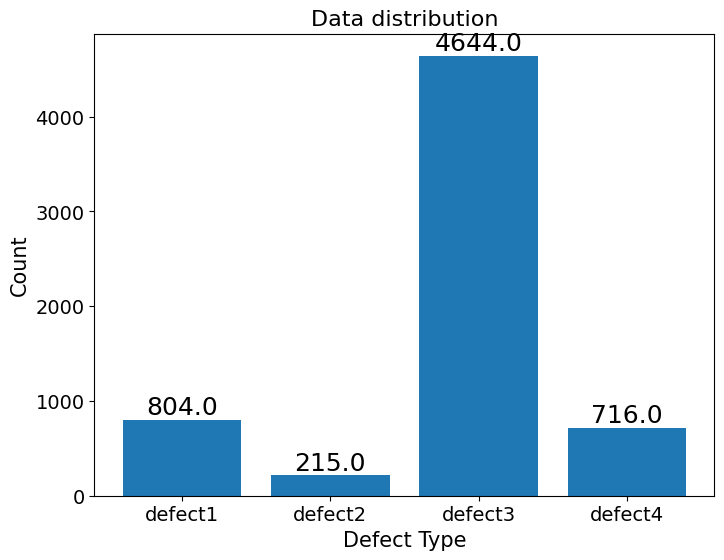

In [ ]:
def show_distribution(df, n_classes, label_name):
  defect_count = []
  for i in range(1,5):
    defect_count.append(np.sum(df.iloc[:,i]!=''))

  plt.figure(figsize=(8,6))
  bar = plt.bar(label_name, defect_count)
  plt.title('Data distribution', fontsize=16)
  plt.ylabel('Count', fontsize=15); plt.xlabel('Defect Type', fontsize=15)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)

  for rect in bar:
      height = rect.get_height()
      plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height,
              ha='center', va='bottom',fontsize=18)
  plt.show()

label_name = ['defect1', 'defect2', 'defect3', 'defect4']
show_distribution(train_df_seg, len(label_name), label_name)


## 2.2. Tile image function

In [ ]:
def add_mask_areas(df):
    '''
    Helper function to add mask area as a new column to the dataframe
    '''
    masks_df = df.copy()
    for i in range(4):
      masks_df['Area_'+str(i+1)] = 0


    for j, row in masks_df.iterrows():
      img = cv2.imread(masks_df['filepaths'].loc[j])
      for k in range(4):
        masks_df['Area_'+str(k+1)].loc[j] = np.sum(rle2mask(row['e'+str(k+1)], width=img.shape[1], height=img.shape[0]))

    return masks_df

In [ ]:
def crop_image(df, save_path, subset='train', crop_w_ratio=0.5, crop_h_ratio=1.0, area_threshold=200):

  """
  Arg:
    df: Dataframe contain image ID and mask rle.
    save_path: The root of directory for saving cropped image and mask.
    crop_w_ratio: The width ratio of slice image and mask.
    crop_h_ratio: The height ratio of slice image and mask.
    area_threshold: Remove image which mask area lower than threshold.
  """

  # Check whether directory is exist in "save_path", or it create directory.
  if subset=='train':
    img_save_path = os.path.join(save_path, 'train_crop_images')

  if subset=='val':
    img_save_path = os.path.join(save_path, 'val_crop_images')

  if os.path.isdir(img_save_path):# start with an empty directory
    shutil.rmtree(img_save_path)

  if not os.path.isdir(img_save_path):
    os.makedirs(img_save_path)

  crop_df = pd.DataFrame(columns=['Image_name', 'e1', 'e2', 'e3', 'e4', 'filepaths'])
  img_crop_list = []
  rle_crop_list = []

  for idx in tqdm(range(len(df))):
    # Load image from Dataframe
    img_root = df['filepaths'].iloc[idx]
    img = cv2.imread(img_root, cv2.IMREAD_GRAYSCALE)

    # Load mask from Dataframe
    mask = np.zeros(shape=(256,1600,4))
    for i in range(4):
      mask[:, :, i] = rle2mask(df['e'+str(i+1)].iloc[idx])

    # # Image and mask be cropped left and right side to 256*1536
    img = img[:,32:img.shape[1]-32]
    mask = mask[:,32:mask.shape[1]-32,:]

    # Define size of image and mask after cropping
    crop_w = img.shape[1]*crop_w_ratio
    crop_h = img.shape[0]*crop_h_ratio

    # Cropping and saving
    for w in range(int(img.shape[1]/crop_w)):
      for h in range(int(img.shape[0]/crop_h)):

        # Cropping image
        img_crop = img[int(h*crop_h):int((h+1)*crop_h),int(w*crop_w):int((w+1)*crop_w)]

        image_name = os.path.splitext(img_root)[0]
        image_name = image_name.split('/')[-1]
        image_name = image_name+'_{}-{}.png'.format(w,h)

        save_root_img = os.path.join(img_save_path, image_name)
        cv2.imwrite(img=img_crop, filename=save_root_img)

        # Cropping mask
        mask_crop = mask[int(h*crop_h):int((h+1)*crop_h), int(w*crop_w):int((w+1)*crop_w), :]
        rles = ['']*4
        for i in range(4):
          if mask_crop[:,:,i].sum()!=0:
            rle = mask2rle(mask_crop[:,:,i])
            rles[i] = rle
        stack_df = pd.DataFrame([[image_name, *rles, save_root_img]] ,columns=['Image_name', 'e1', 'e2', 'e3', 'e4', 'filepaths'])
        crop_df = pd.concat([crop_df, stack_df], axis=0, ignore_index=True)

  # Calculate mask area.
  crop_df_final = add_mask_areas(crop_df)

  # Remove mask area lower than area_threshold.
  for i in range(4):
    crop_df_final['e'+str(i+1)].loc[crop_df_final['Area_'+str(i+1)]<area_threshold]=''

  crop_df_final['count'] = np.sum(crop_df_final.iloc[:,1:5]!='',axis=1).values
  crop_df_final = crop_df_final.drop(crop_df_final[crop_df_final['count']==0].index)

  crop_df_final = sklearn.utils.shuffle(crop_df_final, random_state=2000)
  crop_df_final.reset_index(inplace=True,drop=True)
  crop_df_final.fillna('',inplace=True)

  return crop_df_final

In [ ]:
crop_df_train = crop_image(train_df_seg, subset='train', save_path='/content/kaggle', crop_w_ratio=1/6, crop_h_ratio=1.0, area_threshold=200)
crop_df_val = crop_image(valid_df_seg, subset='val', save_path='/content/kaggle', crop_w_ratio=1/6, crop_h_ratio=1.0, area_threshold=200)

100%|██████████| 5999/5999 [03:54<00:00, 25.58it/s]
<ipython-input-16-cdd633d5c82c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masks_df['Area_'+str(k+1)].loc[j] = np.sum(rle2mask(row['e'+str(k+1)], width=img.shape[1], height=img.shape[0]))
<ipython-input-17-c9365f0c5cc6>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop_df_final['e'+str(i+1)].loc[crop_df_final['Area_'+str(i+1)]<area_threshold]=''
100%|██████████| 667/667 [00:22<00:00, 29.38it/s]
<ipython-input-16-cdd633d5c82c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

In [ ]:
crop_df_train

Image_name                                                 e1  \
0      4fd6b1521_3-0.png                                                      
1      89ef83ab7_0-0.png                                                      
2      16b8b50af_5-0.png                                                      
3      c34f14586_4-0.png                                                      
4      a3714aefc_2-0.png                                                      
...                  ...                                                ...   
14197  606f35768_3-0.png  43010 3 43053 45 43105 4 43266 8 43301 64 4352...   
14198  56774fb7f_3-0.png                                                      
14199  0d4eae8de_3-0.png                                                      
14200  4345c2b85_5-0.png                                                      
14201  949a23e72_3-0.png                                                      

      e2                                                 e3  \
0         84 29 340 29 596 30 852 30 1108 30 1364 30 162...   
1         37379 15 37635 43 37891 72 38147 101 38403 129...   
2         2 214 258 214 514 213 770 213 1026 213 1282 21...   
3         8073 6 8326 18 8579 30 8832 43 9084 56 9337 68...   
4         1 183 212 228 460 236 708 245 956 3397 4481 12...   
...   ..                                                ...   
14197                                                         
14198     1 254 257 254 513 254 769 254 1025 254 1281 25...   
14199                                                         
14200     36131 1 36385 3 36640 5 36895 6 37149 8 37404 ...   
14201                                                         

                                                      e4  \
0                                                          
1      14386 10 14409 12 14634 53 14885 67 15138 75 1...   
2                                                          
3      166 80 423 78 679 77 936 76 1192 75 1449 73 17...   
4                                                          
...                                                  ...   
14197                                                      
14198                                                      
14199  162 87 417 88 673 88 928 89 1184 89 1439 90 16...   
14200                                                      
14201  51203 5 51459 10 51715 11 51971 13 52227 14 52...   

                                               filepaths  Area_1  Area_2  \
0      /content/kaggle/train_crop_images/4fd6b1521_3-...       0       0   
1      /content/kaggle/train_crop_images/89ef83ab7_0-...       0       0   
2      /content/kaggle/train_crop_images/16b8b50af_5-...       0       0   
3      /content/kaggle/train_crop_images/c34f14586_4-...       0       0   
4      /content/kaggle/train_crop_images/a3714aefc_2-...       0       0   
...                                                  ...     ...     ...   
14197  /content/kaggle/train_crop_images/606f35768_3-...    1938       0   
14198  /content/kaggle/train_crop_images/56774fb7f_3-...       0       0   
14199  /content/kaggle/train_crop_images/0d4eae8de_3-...       0       0   
14200  /content/kaggle/train_crop_images/4345c2b85_5-...       0       0   
14201  /content/kaggle/train_crop_images/949a23e72_3-...       0       0   

       Area_3  Area_4  count  
0        3245       0      1  
1        2819    4198      2  
2        1877       0      1  
3        9020    1682      2  
4        9537       0      1  
...       ...     ...    ...  
14197       0       0      1  
14198   10217       0      1  
14199       0   39551      1  
14200    1198       0      1  
14201       0    3974      1  

[14202 rows x 11 columns]

## 2.3. Oversample

In [ ]:
def balance(df, column, working_dir):
    def get_augmented_image(image, mask):
      width = int(image.shape[1])
      height = int(image.shape[0])
      transform = A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.RandomGamma(p=0.5),
          ])
      transformed = transform(image=image, mask=mask)
      image, mask = transformed['image'], transformed['mask']
      return image, mask

    def dummy(image):
      return image

    df = df.copy()
    train_df_balance = pd.DataFrame(columns=['filepaths', 'e1', 'e2', 'e3', 'e4', 'Image_name'])
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')# directory to store augmented images

    if os.path.isdir(aug_dir):# start with an empty directory
      shutil.rmtree(aug_dir)

    if not os.path.exists(aug_dir):
      os.mkdir(aug_dir)

    # create and store the augmented images
    total = 0
    img_paths = []
    rles = []
    img_names = []

    nonan = np.sum(df.loc[:,column]!='', axis=0)
    n = nonan.max() # determine how many samples there are in this class
    max_column = str(nonan.idxmax())
    sample_count = nonan.values

    groups = df.groupby('count') # group by defect count
    count = groups.get_group(1) # one defect

    for idx, label in enumerate(column):  # for every class
      if label != max_column:
        defect = count[count[label]!='']  # a dataframe holding only rows with the specified label
        target_count = len(defect)

        if sample_count[idx] < n: # if the class has less than target number of images
          aug_img_count = 0
          delta = n - sample_count[idx]  # number of augmented images to create
          target_dir = os.path.join(aug_dir, label)

          dir_path = os.path.join(aug_dir,label)

          if not os.path.exists(dir_path):
            os.mkdir(dir_path) # make class directories within aug directory

          desc = f'augmenting class {label}'
          for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
            init_rle = ['']*len(column)
            j = i % target_count
            img_path = defect['filepaths'].iloc[j]
            img_name = defect['Image_name'].iloc[j]
            img = cv2.imread(img_path)

            mask = rle2mask(defect[label].iloc[j], height=img.shape[0], width=img.shape[1])
            img, mask = get_augmented_image(img, mask)

            mask_rle = mask2rle(mask)
            init_rle[idx] = mask_rle

            fname = os.path.basename(img_path)
            fname = fname.split('.')[0]
            fname = 'aug' +str(i) +'-' + fname + '.png'
            dest_path = os.path.join(target_dir, fname) # define where to write the images
            cv2.imwrite(dest_path, img)
            stack_df = pd.DataFrame([[dest_path, *init_rle]], columns=['filepaths', 'e1', 'e2', 'e3', 'e4'])

            train_df_balance = pd.concat([train_df_balance, stack_df], axis=0, ignore_index=True)
            # img_paths.append(dest_path)
            # rles.append(init_rle)
            # img_names.append(img_name)

            aug_img_count +=1
          total +=aug_img_count

    print('Total Augmented images created= ', total)

    train_df = pd.concat([train_df_balance, df],axis=0, ignore_index=True)
    return train_df

# Input full size image
target_columns = ['e1','e2','e3','e4']
working_dir = '/content/kaggle'
train_df_balance_full = balance(crop_df_train, target_columns, working_dir)
train_df_balance_full = sklearn.utils.shuffle(train_df_balance_full, random_state=2000)
train_df_balance_full.reset_index(inplace=True,drop=True)

## 2.4. Data Generater

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip=True,
                  vertical_flip=True,
                  rescale=1/255.0,

                  )

valid_gen = ImageDataGenerator(rescale=1/255.0,
                  )

train_data = train_gen.flow_from_dataframe(train_df_cla_final,
                        directory='/content/kaggle/train_images',
                        x_col='Image_name',
                        y_col='labels',
                        target_size=(256, 1600),
                        color_mode='rgb',
                        class_mode='categorical',
                        classes=None,
                        batch_size=8,
                        shuffle=True,
                        )

valid_data = valid_gen.flow_from_dataframe(valid_df_cla_final,
                        directory='/content/kaggle/train_images',
                        x_col='Image_name',
                        y_col='labels',
                        target_size=(256, 1600),
                        color_mode='rgb',
                        class_mode='categorical',
                        classes=None,
                        batch_size=8,
                        shuffle=False,
                        )

Found 8998 validated image filenames belonging to 5 classes.
Found 1001 validated image filenames belonging to 5 classes.


In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
import cv2
from sklearn.utils import class_weight
import albumentations as A

augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomGamma(gamma_limit=(90, 150), p=0.2) # random.randint(gamma_limit[0], gamma_limit[1]) / 100.0
        ])

path = '/content/kaggle/'
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, df, input_size = (256,1600), batch_size = 8, subset="train", data_path='/content/kaggle/train_images/',
               shuffle=False, pixel_half=False, info={},
               augment_transform=None, plot_mode=False, label_sparse=False, mask_label_mode='multi', normal=True):
    super().__init__()
    self.df = df
    self.shuffle = shuffle
    self.subset = subset
    self.batch_size = batch_size
    self.pixel_half = pixel_half
    self.mask_size = input_size
    self.normal = normal

    if self.pixel_half:
      self.image_size = (int(input_size[0]/2), int(input_size[1]/2)) # (height, width)
    else:
      self.image_size = (input_size[0], input_size[1])


    self.info = info
    self.augment_transform = augment_transform
    self.plot_mode = plot_mode
    self.label_sparse = label_sparse
    self.mask_label_mode = mask_label_mode

    self.on_epoch_end()
    self.data_path = data_path

  def __len__(self):
    return int(np.floor(len(self.df) / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.df))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index):

    if self.plot_mode:
      # store image and label in RGB
      X = np.empty((self.batch_size,self.image_size[0],self.image_size[1],3),dtype=np.float32)
    else:
      # store image and label in grayscale mode
      X = np.empty((self.batch_size,self.image_size[0],self.image_size[1],1),dtype=np.float32)

    # Convert rle to mask
    if self.mask_label_mode =='multi':
      if self.label_sparse:
        y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],1),dtype=np.float32)
      else:
        y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],5),dtype=np.float32)

    if self.mask_label_mode =='binary':
        y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],4),dtype=np.float32)

    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    for i, f in enumerate(self.df['Image_name'].iloc[indexes]):
      path = os.path.join(self.data_path, f)
      self.info[index*self.batch_size+i]=f

      if self.plot_mode:
        # load image in RGB
        image = Image.open(path).convert('RGB')
        if self.normal:
          image = np.array(image).astype(np.float32) / 255.0
        else:
          image = np.array(image).astype(np.float32)
        X[i,] = image

      else:
        # load image in grayscale
        image = Image.open(path).convert('L')
        if self.normal:
          image = np.array(image).astype(np.float32) / 255.0
        else:
          image = np.array(image).astype(np.float32)
        image = image[:,:,np.newaxis]
        X[i,] = image

      if self.subset == 'train' or self.subset == 'val':
        # Convert rle to mask
        if self.mask_label_mode =='multi':
          if self.label_sparse:
            for j in range(4):
              rle_msk = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]], width=self.mask_size[1], height=self.mask_size[0], pixel_half=self.pixel_half)
              rle_msk = rle_msk.astype(np.float32)
              # rle_msk = cv2.resize(rle_msk, (1600,256),interpolation=cv2.INTER_NEAREST)
              y[i,rle_msk==1,0] = j+1

          else:
            for j in range(4):
              rle_msk = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]], width=self.mask_size[1], height=self.mask_size[0], pixel_half=self.pixel_half)
              rle_msk = rle_msk.astype(np.float32)
              y[i,:,:,j+1] = rle_msk
            y[i,:,:,0] = 1-y[i,:,:,1:5].sum(-1)

        if self.mask_label_mode =='binary':
          for j in range(4):
            rle_msk = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]], width=self.mask_size[1], height=self.mask_size[0], pixel_half=self.pixel_half)
            rle_msk = rle_msk.astype(np.float32)
            # rle_msk = cv2.resize(rle_msk, (1600,256),interpolation=cv2.INTER_NEAREST)
            y[i,:,:,j] = rle_msk


        if self.subset == 'train':

          # Agumentation
          if self.augment_transform != None:
            transformed = self.augment_transform(image=X[i,], mask=y[i,])
            X[i,] = transformed['image']
            y[i,] = transformed['mask']

    if self.subset == 'train' or self.subset == 'val':
      return X, y

    else: return X


## 2.5. Show and check generator outputs

Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


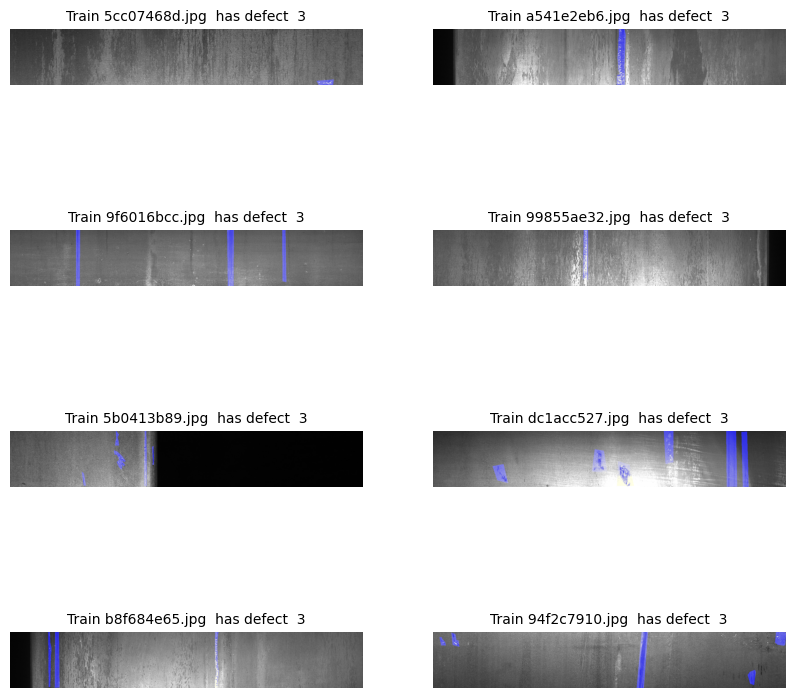

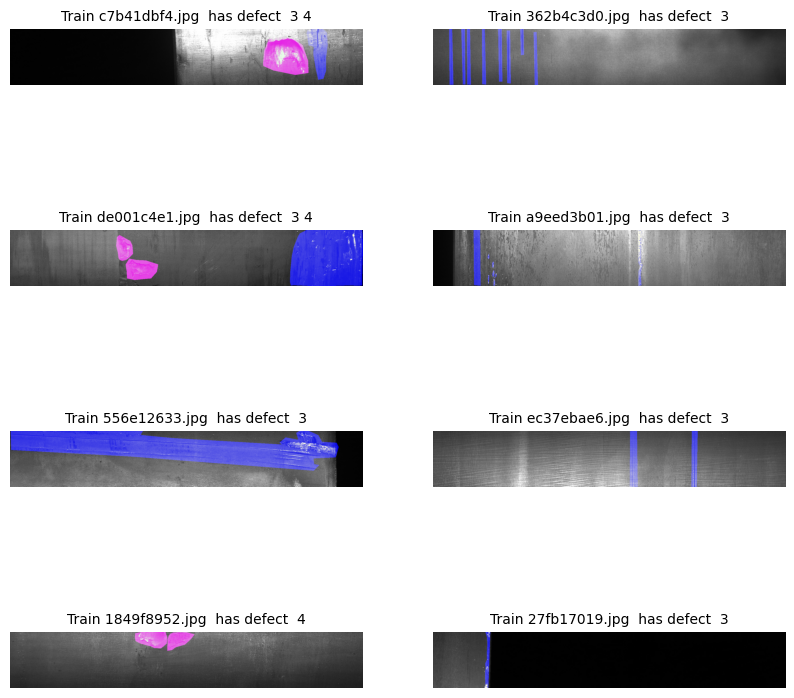

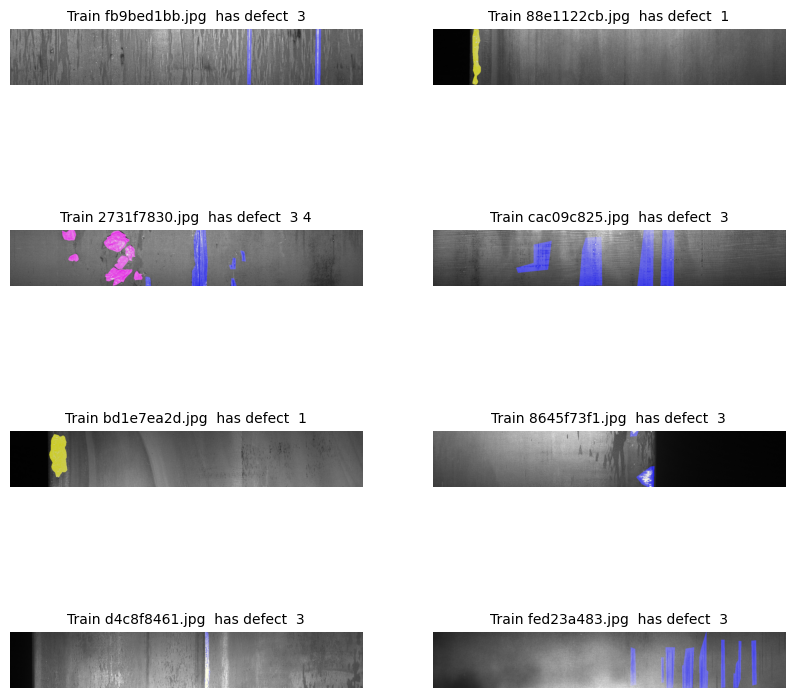

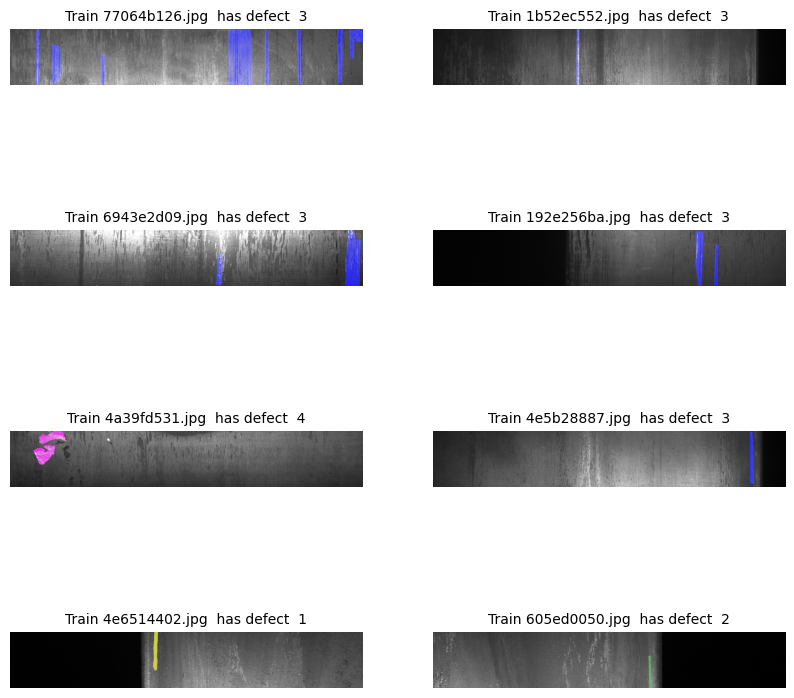

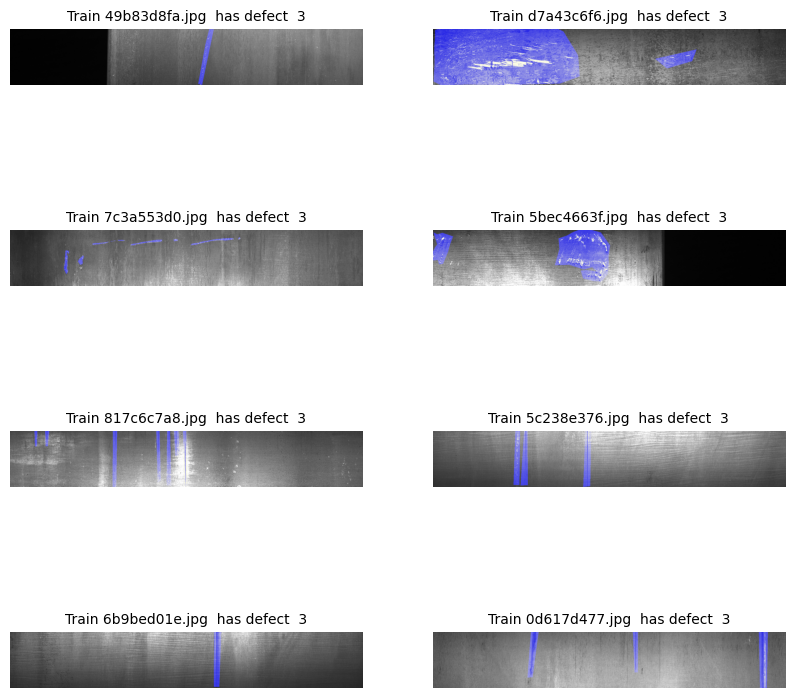

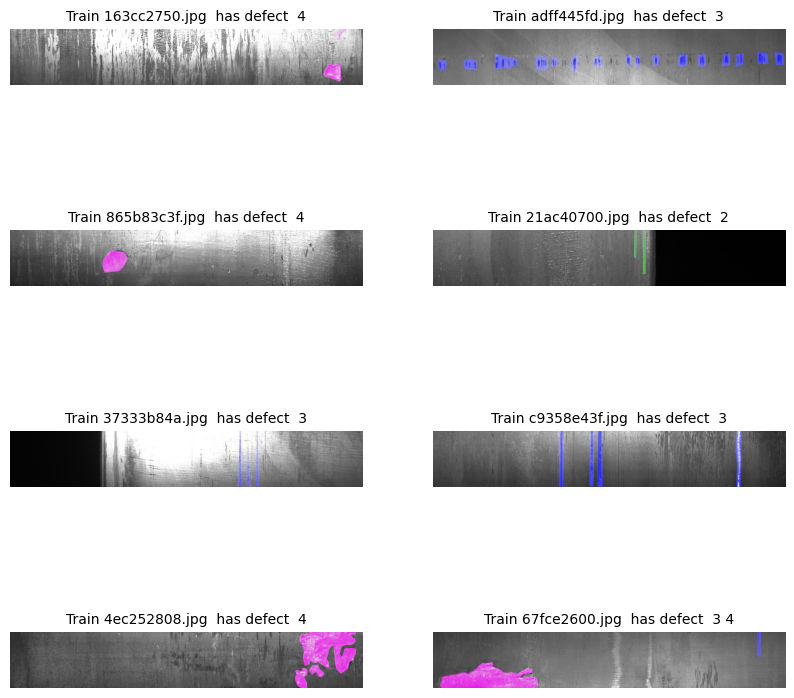

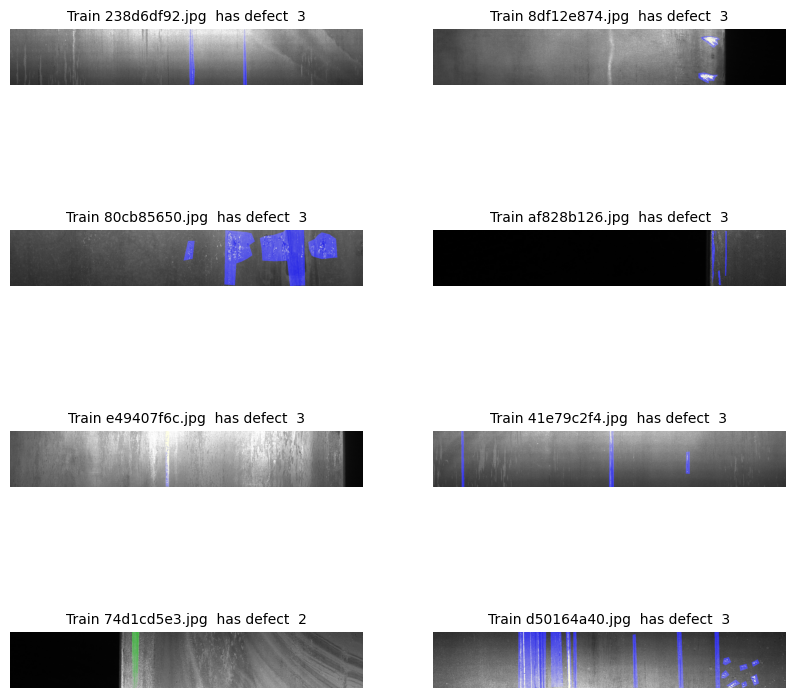

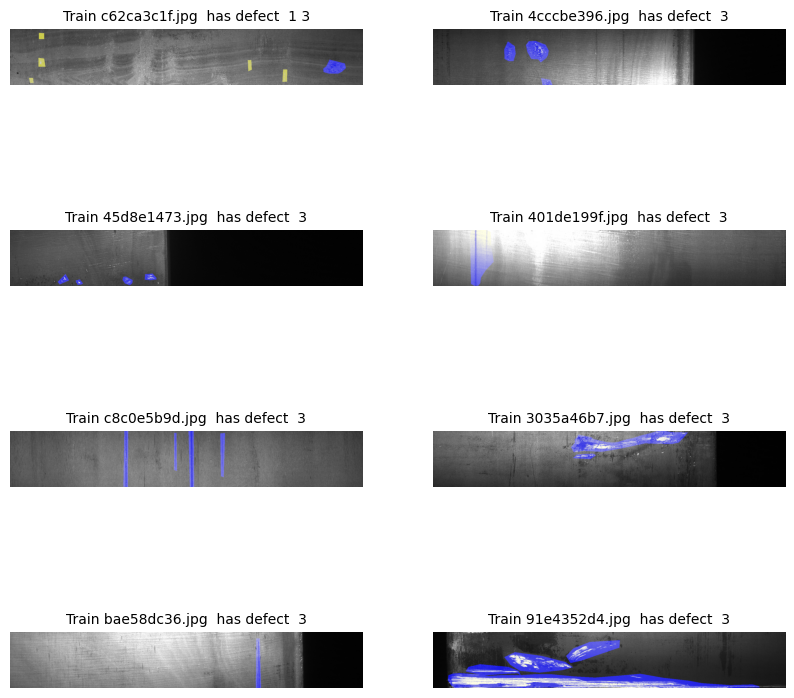

KeyboardInterrupt: ignored

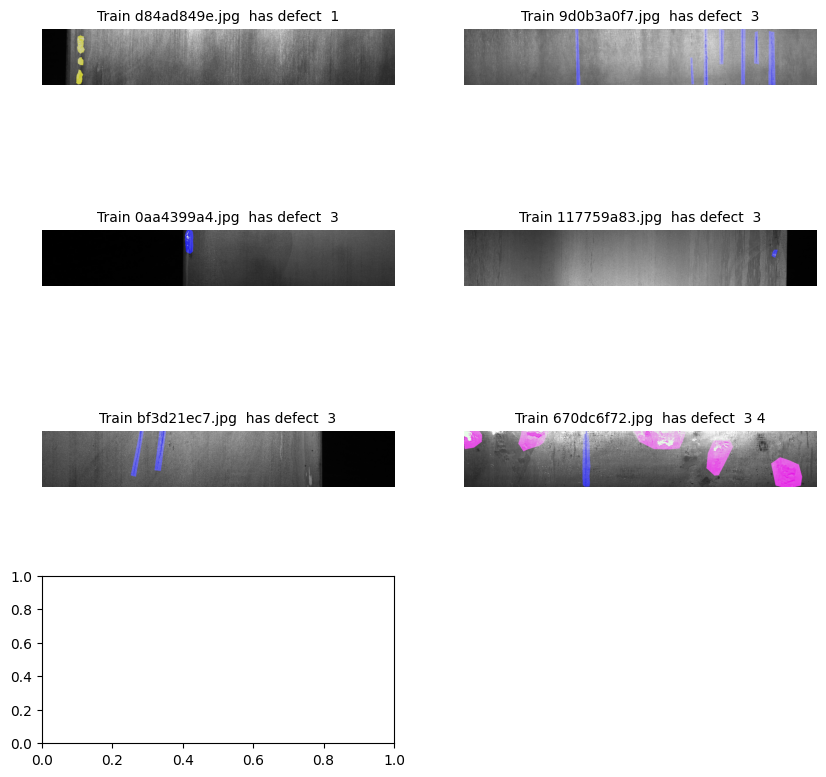

In [ ]:
filenames={}
data_path='/content/kaggle/train_images'
# check = train_df_seg.sample(8)
# data_path= '/content/kaggle/train_crop_images'
# check = crop_df_train.sample(8)
plot_img = DataGenerator(train_df_seg, data_path=data_path, input_size=(256,1600),
                              subset='train', batch_size=8,
                              plot_mode=True, info=filenames, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(plot_img):
  plt.figure(figsize=(10,10))
  for k in range(8):
    plt.subplot(4,2,k+1)
    img_origin = batch[0][k,]
    img_origin_p = img_origin.copy()
    extra = '  has defect '
    msk_origin = batch[1][k,]
    if len(np.unique(msk_origin))>1:
      for m in range(4):
        if np.sum(msk_origin[:,:,m+1])>0:
          extra += ' '+str(m+1)
        if m ==0:
          # yellow
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 0.8
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 0.8

        if m ==1:
          # green
          img_origin_p[msk_origin[:,:,m+1]==1,1] = 0.7

        if m ==2:
          # blue
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 0.9

        if m ==3:
          # magenta
          img_origin_p[msk_origin[:,:,m+1]==1,0] = 0.9
          img_origin_p[msk_origin[:,:,m+1]==1,2] = 0.9

    if extra=='  has defect ': extra =''
    plt.title('Train '+filenames[8*i+k]+extra, fontsize=10)
    plt.axis('off')
    plt.imshow(img_origin_p)
  # plt.subplots_adjust(wspace=0.05)
  plt.show()

# 3.Loss function

## 3.1.Focal binary crossentropy loss

In [ ]:
def get_raw_xentropies(y_true, y_pred):

    xentropies = y_true * tf.math.log(y_pred + K.epsilon()) + (1-y_true) * tf.math.log(1-y_pred + K.epsilon())

    return -xentropies

# multilabel focal loss equals multilabel loss in case of alpha=0.5 and gamma=0
def mutlilabel_focal_loss(y_true, y_pred, class_weights=None, alpha=None, gamma=2):
    """
    Tensorflow version of the Focal Loss
    """
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    xentropies = get_raw_xentropies(y_true, y_pred)

    # compute pred_t:
    y_t = tf.where(tf.equal(y_true,1), y_pred, 1.-y_pred)

    if alpha!=None:

      alpha_t = tf.where(tf.equal(y_true, 1), alpha * tf.ones_like(y_true), (1-alpha) * tf.ones_like(y_true))

      # compute focal loss contributions
      focal_loss_contributions =  tf.multiply(tf.multiply(tf.pow(1-y_t, gamma), xentropies), alpha_t)

    else:
      focal_loss_contributions =  tf.multiply(tf.pow(1-y_t, gamma), xentropies)

    # our focal loss contributions have shape (n_samples, s_classes), we need to reduce with mean over samples:
    focal_loss_per_class = tf.reduce_mean(focal_loss_contributions, axis=0)

    # compute the overall loss if class weights are None (equally weighted):
    if class_weights is None:
        focal_loss_result = tf.reduce_mean(focal_loss_per_class)
    else:
        # weight the single class losses and compute the overall loss
        weights = tf.constant(class_weights, dtype=tf.float64)
        focal_loss_result = tf.reduce_mean(tf.multiply(weights, focal_loss_per_class))
    return focal_loss_result

class MutlilabelFocal(tf.keras.losses.Loss):

  def __init__(self, class_weights=None, alpha=0.25, gamma=2):
    super().__init__(name='mutlilabel_focal_loss')
    self.class_weights = class_weights
    self.alpha = alpha
    self.gamma = gamma

  def __call__(self, y_true, y_pred, **kwargs):
    return mutlilabel_focal_loss(
        y_true,
        y_pred,
        class_weights=self.class_weights,
        alpha = self.alpha,
        gamma = self.gamma
      )

## 3.2.Focal tversky loss + categorical cross entropy loss

In [ ]:
def weighted_categorical_crossentropy(y_true, y_pred, class_weights=1.):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # scale predictions so that the class probas of each sample sum to 1
  y_pred /= K.sum(y_pred, axis=3, keepdims=True)
  # clip to prevent NaN's and Inf's
  y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
  # calc
  loss = y_true * K.log(y_pred)* class_weights
  return - K.mean(loss)

class weighted_categoricalCE_loss(tf.keras.losses.Loss):

  def __init__(self, class_weights=None):
    super().__init__(name='weighted_categorical_crossentropy')
    self.class_weights = class_weights if class_weights is not None else 1

  def __call__(self, y_true, y_pred, **kwargs):
    return weighted_categorical_crossentropy(
        y_true,
        y_pred,
        class_weights=self.class_weights
      )

def dice_loss(y_true, y_pred, smooth=1e-6):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Get batch size
  bs = tf.shape(y_true)[0]

  # Flat array to (batch, H*W)
  y_pred_f = tf.reshape(y_pred[:,:,:,1:], [bs, -1]) # ignore background class
  y_true_f = tf.reshape(y_true[:,:,:,1:], [bs, -1]) # ignore background class

  # Calculate
  intersection = y_true_f * y_pred_f
  dice_score = 2 * (K.sum(intersection, axis=1) + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)
  return 1 - K.mean(dice_score, axis=0)


class DiceLoss(tf.keras.losses.Loss):
  def __init__(self, class_weights=None, smooth=1e-6):
    super().__init__(name='dice_loss')
    self.smooth = smooth

  def __call__(self, y_true, y_pred, **kwargs):
    return dice_loss(
        y_true,
        y_pred,
        smooth=self.smooth
      )

def tversky_Loss(targets, inputs, alpha=0.7, smooth=1e-6):
  #flatten label and prediction tensors
  inputs_f = K.flatten(inputs[:,:,:,1:])
  targets_f = K.flatten(targets[:,:,:,1:])

  #True Positives, False Positives & False Negatives
  TP = K.sum((inputs_f * targets_f))
  FP = K.sum(((1-targets_f) * inputs_f))
  FN = K.sum((targets_f * (1-inputs_f)))

  Tversky = (TP + smooth) / (TP + alpha*FP + (1-alpha)*FN + smooth)
  return 1-Tversky

def focal_tversky_Loss(y_true, y_pred, alpha=0.7, gamma=2.0, smooth=1e-6, class_weights=1.0):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  TP = K.sum((y_pred * y_true), axis=[0,1,2])
  FP = K.sum(((1-y_true) * y_pred), axis=[0,1,2])
  FN = K.sum((y_true * (1-y_pred)), axis=[0,1,2])

  Tversky = (TP + smooth) / (TP + (1-alpha)*FP + alpha*FN + smooth)
  loss = K.pow((1 - Tversky), gamma)*class_weights

  return K.mean(loss, axis=0)


class TverskyLoss(tf.keras.losses.Loss):
  def __init__(self, alpha=0.7, smooth=1e-6):
    super().__init__(name='TverskyLoss')
    self.smooth = smooth
    self.alpha = alpha

  def __call__(self, y_true, y_pred, **kwargs):
    return tversky_Loss(
        y_true,
        y_pred,
        smooth=self.smooth,
        alpha = self.alpha
      )


class FocalTverskyLoss(tf.keras.losses.Loss):
  def __init__(self, alpha=0.3, gamma=2.0, smooth=1e-6, class_weights=1.0):
    super().__init__(name='FocalTverskyLoss')
    self.smooth = smooth
    self.alpha = alpha
    self.gamma = gamma
    self.class_weights = class_weights

  def __call__(self, y_true, y_pred, **kwargs):
    return focal_tversky_Loss(
        y_true,
        y_pred,
        smooth=self.smooth,
        alpha = self.alpha,
        gamma = self.gamma,
        class_weights = self.class_weights
      )

class DiceCCELoss(tf.keras.losses.Loss):

  def __init__(self, class_weights=None, smooth=K.epsilon(), CCE_weights=0.5, Dice_weights=0.5):
    super().__init__(name='CCE_dice_loss')
    self.class_weights = class_weights if class_weights is not None else 1
    self.smooth = smooth
    self.CCE_weights = CCE_weights
    self.Dice_weights = Dice_weights

    if self.CCE_weights !=0:
      self.cce_loss = weighted_categoricalCE_loss(class_weights=self.class_weights)

    if self.Dice_weights !=0:
      self.dice_loss = DiceLoss(smooth=self.smooth)

  def __call__(self, y_true, y_pred, **kwargs):

    if self.CCE_weights ==0:
      return self.cce_loss(y_true, y_pred)

    if self.Dice_weights ==0:
      return self.dice_loss(y_true, y_pred)

    cce = self.cce_loss(y_true, y_pred)
    dice = self.dice_loss(y_true, y_pred)
    loss = self.CCE_weights*cce + self.Dice_weights*dice
    return loss

class TverskyCCELoss(tf.keras.losses.Loss):

  def __init__(self, class_weights=None, smooth=K.epsilon(), CCE_weights=0.5, tversky_weights=0.5, alpha=0.7):
    super().__init__(name='Tversky_CCE_loss')
    self.class_weights = class_weights if class_weights is not None else 1
    self.smooth = smooth
    self.CCE_weights = CCE_weights
    self.tversky_weights = tversky_weights
    self.alpha = alpha

    if self.CCE_weights !=0:
      self.cce_loss = weighted_categoricalCE_loss(class_weights=self.class_weights)

    if self.tversky_weights !=0:
      self.tversky_loss = TverskyLoss(smooth=self.smooth, alpha=self.alpha)

  def __call__(self, y_true, y_pred, **kwargs):

    if self.CCE_weights ==0:
      return self.cce_loss(y_true, y_pred)

    if self.tversky_weights ==0:
      return self.tversky_loss(y_true, y_pred)

    cce = self.cce_loss(y_true, y_pred)
    tversky = self.tversky_loss(y_true, y_pred)
    loss = self.CCE_weights*cce + self.tversky_weights*tversky
    return loss

class FocalTversky_CCELoss(tf.keras.losses.Loss):

  def __init__(self, class_weights=1.0, smooth=K.epsilon(), CCE_weights=0.5, focal_tversky_weights=0.5, alpha=0.3, gamma=2.0):
    super().__init__(name='FocalTversky_CCE_loss')
    self.class_weights = class_weights if class_weights is not None else 1
    self.smooth = smooth
    self.CCE_weights = CCE_weights
    self.focal_tversky_weights = focal_tversky_weights
    self.alpha = alpha
    self.gamma = gamma
    self.class_weights = class_weights

    if self.CCE_weights !=0:
      self.cce_loss = weighted_categoricalCE_loss(class_weights=self.class_weights)

    if self.focal_tversky_weights !=0:
      self.focal_tversky_loss = FocalTverskyLoss(smooth=self.smooth, alpha=self.alpha, gamma=self.gamma, class_weights=self.class_weights)

  def __call__(self, y_true, y_pred, **kwargs):

    if self.CCE_weights ==0:
      return self.cce_loss(y_true, y_pred)

    if self.focal_tversky_weights ==0:
      return self.focal_tversky_weights(y_true, y_pred)

    cce = self.cce_loss(y_true, y_pred)
    focal_tversky = self.focal_tversky_loss(y_true, y_pred)
    loss = self.CCE_weights*cce + self.focal_tversky_weights*focal_tversky
    return loss

## 3.3.Weighted_binary_crossentropy

In [ ]:
def weighted_bce(y_true, y_pred, class_weights=None):

  y_true = tf.cast(y_true, tf.float64)
  y_pred = tf.cast(y_pred, tf.float64)

  bce = K.binary_crossentropy(y_true, y_pred)

  if class_weights!=None:
    weighted_bce = K.mean(bce * class_weights)
    return weighted_bce

  else:
    return K.mean(bce)

class WeightBCE(tf.keras.losses.Loss):

  def __init__(self, class_weights=None):
    super().__init__(name='weighted_bce')
    self.class_weights = class_weights

  def __call__(self, y_true, y_pred, **kwargs):
    return weighted_bce(
        y_true,
        y_pred,
        class_weights=self.class_weights,

      )

# 4.Metics function

## 4.1. F1 Score

In [ ]:
class F1_score(tf.keras.metrics.Metric):

  def __init__(self, name='F1_score', threshold=0.5, average=True, ignore_ground=False, num_classes=5, task='clf', **kwargs):
    super().__init__(name=name, **kwargs)

    self.task = task
    if self.task =='clf':
      self.axes = [0]

    if self.task =='segment':
      self.axes = [0,1,2]

    self.num_classes = num_classes
    self.true_positives = self.add_weight(shape=(self.num_classes,), name='tp', initializer='zeros')
    self.false_positives = self.add_weight(shape=(self.num_classes,), name='fp', initializer='zeros')
    self.false_negatives = self.add_weight(shape=(self.num_classes,), name='fn', initializer='zeros')
    self.threshold = threshold
    self.average = average
    self.ignore_ground = ignore_ground

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, 'float')

    if not self.threshold:
      y_pred = tf.one_hot(tf.math.argmax(tf.cast(y_pred, 'float'), axis=3), depth=self.num_classes)

    else:
      y_pred = tf.cast(tf.greater(tf.cast(y_pred, 'float'), self.threshold), 'float')


    self.true_positives.assign_add(tf.reduce_sum(tf.multiply(y_true,y_pred), axis=self.axes))
    self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred, axis=self.axes))
    self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred), axis=self.axes))

  def result(self):
    p = self.true_positives / (self.true_positives + self.false_positives)
    r = self.true_positives / (self.true_positives + self.false_negatives)

    f1 = 2*( p * r ) / (p + r)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    if self.ignore_ground:
      f1 = f1[1:]

    if not self.average:
      return f1

    else:
      return tf.experimental.numpy.nanmean(f1)

  def reset_state(self):
    self.true_positives.assign(tf.zeros(shape=(self.num_classes,)))
    self.false_positives.assign(tf.zeros(shape=(self.num_classes,)))
    self.false_negatives.assign(tf.zeros(shape=(self.num_classes,)))

# 5.Callback function

## 5.1. Gradient accumulation

In [ ]:
# 梯度累積
from tensorflow.keras.optimizers import Optimizer
import tensorflow.keras.backend as K


class AccumOptimizer(Optimizer):

    #需要name属性
    def __init__(self,optimizer,steps_per_update=1,**kwargs):
        self.name=kwargs['name']
        super(AccumOptimizer,self).__init__(**kwargs)
        self.optimizer=optimizer
        with tf.name_scope(self.__class__.__name__):
            self.steps_per_update=steps_per_update
            self.iterations=tf.Variable(0,dtype='int64',name='iterations')
            self.cond=tf.equal(self.iterations%self.steps_per_update,0)
            self.lr=self.optimizer.lr
            self.optimizer.lr=tf.cond(self.cond,lambda:self.optimizer.lr.value(), lambda:0.)
            for attr in ['momentum', 'rho', 'beta_1', 'beta_2']:
                if hasattr(self.optimizer,attr):
                    #保存操作
                    value=getattr(self.optimizer,attr)
                    setattr(self, attr, value)
                    setattr(self.optimizer, attr, tf.cond(self.cond, lambda:value.value(), lambda:1 - 1e-7))
            for attr in self.optimizer.get_config():
                if not hasattr(self, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)

            self._create_slots=self.optimizer._create_slots
            self._resource_apply_dense=self.optimizer._resource_apply_dense

            # 覆盖原有的獲取梯度方法，指向累積梯度
            def get_gradients(loss,params):
                return [ag / self.steps_per_update for ag in self.accum_grads]
            self.optimizer.get_gradients = get_gradients

    def get_updates(self,loss,params):
        self.iterations=tf.add(self.iterations, 1)
        self.optimizer.iterations=tf.add(self.optimizer.iterations, tf.cast(self.cond, 'int64'))
        self.updates=[
            self.iterations,
            self.optimizer.iterations
        ]
        # 累積梯度 (gradient accumulation)
        self.accum_grads = [tf.zeros(p.shape,dtype=p.dtype) for p in params]
        grads = self.get_gradients(loss, params)

        for g, ag in zip(grads, self.accum_grads):
            self.updates.append(ag=tf.cond(self.cond,lambda:g,lambda:ag+g))

        # 繼承optimizer的更新 (inheriting updates of original optimizer)
        self.updates.extend(self.optimizer.get_updates(loss, params)[1:])
        self.weights.extend(self.optimizer.weights)
        return self.updates

    def get_config(self):
        iterations = self.iterations.numpy()
        self.iterations=0
        config = self.optimizer.get_config()
        self.iterations=iterations
        return config

## 5.2. Warmup + Cosine decay

In [ ]:
def lr_warmup_cosine_decay(dataset, global_step, warmup_steps_ratio=0.05, epochs=100, hold=0, start_lr=0.0, target_lr=1e-3, warmup=True):

  total_steps = len(dataset)* epochs
  warmup_steps = int(warmup_steps_ratio * total_steps)
  if warmup:
    # Cosine decay
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = np.where(global_step > warmup_steps + hold,
                                learning_rate, target_lr)

    learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)

  else:
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - hold) / float(total_steps - hold)))
  return learning_rate

class WarmupCosineDecay(tf.keras.callbacks.Callback):
    def __init__(self, dataset, optimizer, warmup_steps_ratio=0.05, epochs=100, warmup_steps=0, start_lr=0.0, target_lr=1e-3, hold=0, warmup=True):
      self.dataset = dataset
      self.start_lr = start_lr
      self.hold = hold
      self.global_step = 0
      self.target_lr = target_lr
      self.warmup_steps = warmup_steps
      self.lrs = []
      self.optimizer = optimizer
      self.epochs = epochs
      self.warmup_steps_ratio = warmup_steps_ratio
      self.warmup = warmup

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = self.optimizer.lr.numpy()
        self.lrs.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = lr_warmup_cosine_decay(
                        epochs = self.epochs,
                        dataset = self.dataset,
                        warmup_steps_ratio = self.warmup_steps_ratio,
                        global_step=self.global_step,
                        start_lr=self.start_lr,
                        target_lr=self.target_lr,
                        hold=self.hold,
                        warmup = self.warmup
                        )
        K.set_value(self.optimizer.lr, lr)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.lr)

# 6.Classification

## 6.1. EfficientNet model

In [ ]:
del model

In [ ]:
def classification_model(num_classes=5):
  base_model = tf.keras.applications.EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=(256,1600,3))
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2, name="top_dropout1")(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2, name="top_dropout2")(x)

  output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

  # adamW = tf.keras.optimizers.AdamW(learning_rate=8.1326e-07, weight_decay=0.00001)
  sgd = tf.keras.optimizers.SGD(learning_rate=1e-07, momentum=0.9, weight_decay=0.00001)
  # wbce = WeightBCE(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])
  adam = tf.keras.optimizers.Adam(learning_rate=4.9213e-06)
  focalbce = MutlilabelFocal(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5], alpha=None, gamma=2.0)
  f1 = F1_score(threshold=0.5, average=True, ignore_ground=False, num_classes=num_classes, task='clf')

  model.compile(
          optimizer=adam,
          loss=focalbce,
          metrics=[f1]
          )
  return model

with one_strategy.scope():
  model = classification_model(num_classes=5)

In [ ]:
model.summary()

In [ ]:
# model.load_weights('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/classify-b3_focal_non_50_2.hdf5')

### 6.1.1. Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=True,
    mode='min',
    cooldown=5,
    min_lr=1e-09,
    eps=1e-09
    )

checkpoint_filepath = '/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/classify-b3_focal_non_50_3.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=True)

log_csv = CSVLogger('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/classification/log-b3_focal_non_50_3.csv', separator=',', append=False)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10 , mode = 'min')



In [ ]:
epochs = 80

lr_callback = WarmupCosineDecay(
                  epochs = epochs,
                  dataset = train_data,
                  optimizer = model.optimizer,
                  warmup_steps_ratio=0.05,
                  hold=0,
                  start_lr=0.0,
                  target_lr=1e-3
                  )
# Callback list
callback_list = [log_csv, model_checkpoint_callback, es, lr_callback]

history = model.fit(train_data, validation_data = valid_data, epochs=epochs ,verbose=1, callbacks=callback_list)

### 6.1.2. Evaluating

In [ ]:
from sklearn.metrics import classification_report

thresholds = [0.5, 0.5, 0.5, 0.5, 0.5]

valid_data.reset()
for i, valid_batch in enumerate(tqdm(valid_data)):

  if i >= len(valid_data):
    break

  y_true = valid_batch[1]
  predict = model.predict(valid_batch[0], verbose=0)

  for t in range(5):

    predict[predict[:,t]>thresholds[t],t] = 1
    predict[predict[:,t]<thresholds[t],t] = 0

  if i==0:
    true_all = y_true
    pred_all = predict

  true_all = np.append(true_all, y_true, axis=0)
  pred_all = np.append(pred_all, predict, axis=0)

# Create precision, recall, f1-score report each class
print('/n')
labels =['background', 'defect1', 'defect2', 'defect3', 'defect4']
print(classification_report(true_all, pred_all, target_names=labels))

100%|██████████| 125/125 [01:03<00:00,  1.96it/s]

              precision    recall  f1-score   support

  background       0.92      0.88      0.90       332
     defect1       0.77      0.81      0.79        85
     defect2       0.71      0.71      0.71        21
     defect3       0.94      0.86      0.90       526
     defect4       0.94      0.91      0.92        98

   micro avg       0.91      0.87      0.89      1062
   macro avg       0.86      0.84      0.85      1062
weighted avg       0.92      0.87      0.89      1062
 samples avg       0.88      0.88      0.87      1062




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
xx = tf.keras.applications.ResNet50V2(include_top=False,
                              weights="imagenet",
                                       input_shape=(256,1600,3))

In [ ]:
xx.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 1606, 3  0           ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 800, 64  9472        ['conv1_pad[0][0]']              
                                )                                                        

In [ ]:
gg = tf.keras.applications.EfficientNetB2(
        weights="imagenet", include_top=False, input_shape=(256,1600,3))

In [ ]:
gg.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 rescaling_10 (Rescaling)       (None, 256, 1600, 3  0           ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 normalization_5 (Normalization  (None, 256, 1600, 3  7          ['rescaling_10[0][0]']           
 )                              )                                                    

# 7.Segmentation

## 7.0.Show image with mask

In [ ]:
def generate_image_w_mask(data_generator, model, figure_size=(20,36)):

  print('Plotting predictions...')
  print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')
  preds = model.predict(data_generator, verbose=1)

  for i,batch in enumerate(data_generator):
      plt.figure(figsize=figure_size)
      for k in range(data_generator.batch_size):
          plt.subplot(data_generator.batch_size, 2, 2*k+1)
          img = batch[0][k,]
          if not data_generator.normal:
            img_1 = img.copy() /255.0
            img_2 = img.copy() /255.0

          else:
            img_1 = img.copy()
            img_2 = img.copy()

          extra = '  has defect '
          msk = batch[1][k,]
          if len(np.unique(msk))>1:
            for n in range(4):
              if n ==0:
                # yellow
                img_1[msk[:,:,n+1]==1,0] = 0.8
                img_1[msk[:,:,n+1]==1,1] = 0.8
              if n ==1:
                # green
                img_1[msk[:,:,n+1]==1,1] = 0.6
              if n ==2:
                # blue
                img_1[msk[:,:,n+1]==1,2] = 0.9
              if n ==3:
                # magenta
                img_1[msk[:,:,n+1]==1,0] = 0.9
                img_1[msk[:,:,n+1]==1,2] = 0.9

          if extra=='  has defect ': extra =''
          plt.title('Train '+valid_df_seg.iloc[16*i+k,0])
          plt.axis('off')
          plt.imshow(img_1)

  ############################# Plot Predict reslut #############################################
          plt.subplot(data_generator.batch_size, 2,2*k+2)
          extra_pred = ' has defect'

          thresholded = np.argmax(preds[data_generator.batch_size*i+k,], axis=2)

          # yellow
          img_2[thresholded==1,0] = 0.8
          img_2[thresholded==1,1] = 0.8
          # green
          img_2[thresholded==2,1] = 0.6
          # blue
          img_2[thresholded==3,2] = 0.9
          # magenta
          img_2[thresholded==4,0] = 0.9
          img_2[thresholded==4,2] = 0.9

          plt.axis('off')
          plt.title('Predict Defect ')
          plt.subplots_adjust(wspace=0.05)
          plt.imshow(img_2)

      plt.subplots_adjust(wspace=0.05)
      plt.show()

## 7.1.Unet

In [ ]:
class Unet_efficnet :
  def __init__(self, input_shape, classes):
    tf.keras.backend.clear_session()
    self.input_shape = input_shape
    self.classes = classes
    self.inputs = tf.keras.layers.Input(input_shape)
    self.encoder = tf.keras.applications.EfficientNetB4(include_top='False', weights='imagenet', input_tensor= self.inputs)

  def conv_block(self, inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same", kernel_initializer='he_uniform')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same", kernel_initializer='he_uniform')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

  def decoder_block(self, inputs, skip, num_filters):
      # x = tf.keras.layers.Conv2DTranspose(num_filters, (3, 3), strides=2, padding="same")(inputs)
      x = tf.keras.layers.UpSampling2D((2,2), interpolation="bilinear")(inputs)
      x = tf.keras.layers.Concatenate()([x, skip])
      x = self.conv_block(x, num_filters)
      return x

  def build_efficient_unet(self):
    print(self.encoder.get_layer("rescaling_1").output)
    s1 = self.encoder.get_layer("input_1").output  #skip connection 256X1600
    print(K.int_shape(s1))
    s2 = self.encoder.get_layer("block2a_expand_activation").output  #skip connection 128X800
    print(K.int_shape(s2))
    s3 = self.encoder.get_layer("block3a_expand_activation").output  #skip connection 64X400
    print(K.int_shape(s3))
    s4 = self.encoder.get_layer("block4a_expand_activation").output  #skip connection 32X200
    print(K.int_shape(s4))
    s5 = self.encoder.get_layer("block6a_expand_activation").output  #skip connection 16X100
    print(K.int_shape(s5))
    """ Bottle neck"""

    b1 = self.encoder.get_layer("top_activation").output  # 8X50

    """decoder block"""
    d1 = self.decoder_block(b1,s5,256) #16 X 100 X 512

    d2 = self.decoder_block(d1,s4,128) #32 X 200 X 256

    d3 = self.decoder_block(d2,s3,64) #64 X 400 X 128

    d4 = self.decoder_block(d3,s2,32) #128 X 800 X 64

    d5 = self.decoder_block(d4,s1,16) #256 X 1600 X 32

    # (None, 128, 800, 144)
    # (None, 64, 400, 192)
    # (None, 32, 200, 336)
    # (None, 16, 100, 960)

    """Output"""
    outputs = tf.keras.layers.Conv2D(self.classes, kernel_size=(3, 3), padding = "same" ,kernel_initializer='glorot_uniform')(d5)
    outputs = tf.keras.layers.Activation('softmax', name='softmax')(outputs)

    unet_model = tf.keras.Model(self.inputs , outputs, name = "EfficientNetB2_UNET")

    return  unet_model

In [ ]:
!git clone https://github.com/qubvel/efficientnet.git

Cloning into 'efficientnet'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 310 (delta 1), reused 1 (delta 0), pack-reused 305
Receiving objects: 100% (310/310), 835.11 KiB | 2.59 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [ ]:
!cd /content/efficientnet
# from efficientnet.efficientnet import EfficientNetB4

# backbone = EfficientNetB4(weights='imagenet',
#                             include_top=False,
#                             input_shape=input_shape)

In [ ]:
backbone = tf.keras.applications.EfficientNetB4(weights=None,
                            include_top=False,
                            input_shape=(256,1600,3))

backbone.summary()

AttributeError: ignored

In [ ]:
xxx = tf.keras.applications.EfficientNetV2B3(weights=None,
                            include_top=False,
                            input_shape=(256,1600,3))


xxx.summary()

Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 256, 1600, 3  0           ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 normalization_3 (Normalization  (None, 256, 1600, 3  0          ['rescaling_4[0][0]']            
 )                              )                                                 

### 7.1.1. Training

In [ ]:
from tensorflow_addons.optimizers import CyclicalLearningRate

batch_size=24
train_batches = DataGenerator(train_df_seg[:], subset='train', input_size=(256,1600), batch_size=4, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
valid_batches = DataGenerator(valid_df_seg[:], subset='val', input_size=(256,1600), batch_size=4, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, label_sparse=False, mask_label_mode='multi')

steps_per_epoch = len(train_df_seg) // batch_size

clr = CyclicalLearningRate(initial_learning_rate=1e-06,
    maximal_learning_rate=1e-4,
    scale_fn= lambda x: 0.8 ** (x),
    step_size=2 * steps_per_epoch,

)

adam = tf.keras.optimizers.Adam(learning_rate=clr)
adamW = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-05, weight_decay=0.00001)
sgd = tf.keras.optimizers.SGD(learning_rate=1e-04, momentum=0.9, weight_decay=0.00001)

tcl = TverskyCCELoss(CCE_weights=0.6, tversky_weights=0.4, alpha=0.7) # Tversky = (TP + smooth) / (TP + (1-alpha)*FP + (alpha)*FN + smooth)
ftcl = FocalTversky_CCELoss(CCE_weights=0.6, focal_tversky_weights=0.4, alpha=0.3, gamma=2.0, class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])
wcce = weighted_categoricalCE_loss(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])


ueff = Unet_efficnet(input_shape = (256,1600,3), classes = 5 )
unet_model = ueff.build_efficient_unet()
unet_model.compile(optimizer=adam,
              loss = ftcl,
              metrics=[F1_score(threshold=None, average=True, ignore_ground=True, task='segment', num_classes=5)])

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 1600, 3), dtype=tf.float32, name=None), name='rescaling_1/add:0', description="created by layer 'rescaling_1'")
(None, 256, 1600, 3)
(None, 128, 800, 144)
(None, 64, 400, 192)
(None, 32, 200, 336)
(None, 16, 100, 960)


In [ ]:
unet_model.summary()

Model: "EfficientNetB2_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 rescaling (Rescaling)          (None, 256, 1600, 3  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 normalization (Normalization)  (None, 256, 1600, 3  7           ['rescaling[0][0]']              
                                )                                               

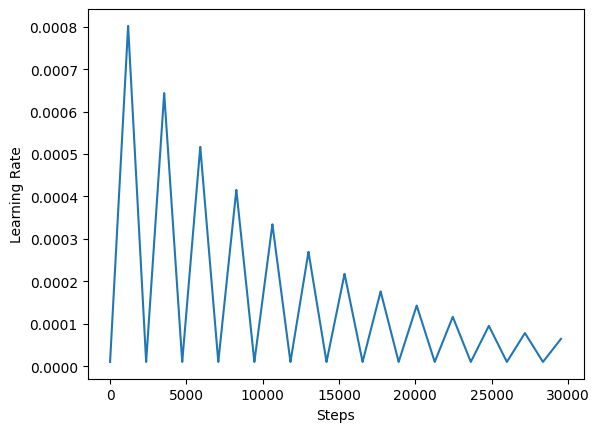

In [ ]:
step = np.arange(0, 50 * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
unet_model.load_weights('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/Unet_eff4b_fcal_crop_7.31.hdf5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

checkpoint_filepath = '/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/Unet_eff4b_fcal_crop_7.31_2.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=True)

reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode='min',
    min_delta=0.0001,
    cooldown=5,
    min_lr=0,)

log_csv = CSVLogger('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/FPN_EfficientNet_cce-dice_cw_aug4_crop256-416_radam-b4_GA/log_Unet_eff4b_fcal_crop_7.31_2.csv', separator=',', append=False)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10 , mode = 'min')

In [ ]:
epochs = 50

class Get_Lr(tf.keras.callbacks.Callback):
  def __init__(self, optimizer):
    self.lrs = []
    self.optimizer = optimizer

  def on_epoch_end(self, epoch, logs=None):
      logs = logs or {}
      logs["lr"] = K.get_value(self.model.optimizer.lr)

get_lr = Get_Lr(unet_model.optimizer)

callback_list = [log_csv, model_checkpoint_callback, es, get_lr]

history = unet_model.fit(train_batches, validation_data = valid_batches, epochs=epochs ,verbose=1, callbacks=callback_list)

Epoch 1/50
591/591 [==============================] - 412s 399ms/step - loss: 0.4104 - F1_score: 0.7328 - val_loss: 0.4269 - val_F1_score: 0.7133 - lr: 4.0533e-05
Epoch 2/50
591/591 [==============================] - 224s 379ms/step - loss: 0.4032 - F1_score: 0.7277 - val_loss: 0.4303 - val_F1_score: 0.7113 - lr: 8.0133e-05
Epoch 3/50
591/591 [==============================] - 236s 398ms/step - loss: 0.4119 - F1_score: 0.7321 - val_loss: 0.4298 - val_F1_score: 0.7055 - lr: 4.0667e-05
Epoch 4/50
591/591 [==============================] - 235s 397ms/step - loss: 0.4060 - F1_score: 0.7325 - val_loss: 0.4303 - val_F1_score: 0.7046 - lr: 1.0670e-06
Epoch 5/50
591/591 [==============================] - 227s 383ms/step - loss: 0.4015 - F1_score: 0.7450 - val_loss: 0.4292 - val_F1_score: 0.7050 - lr: 3.2626e-05
Epoch 6/50
591/591 [==============================] - 225s 381ms/step - loss: 0.3970 - F1_score: 0.7421 - val_loss: 0.4302 - val_F1_score: 0.6947 - lr: 6.4306e-05
Epoch 7/50
591/591 [==

KeyboardInterrupt: ignored

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
adamW = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-05, weight_decay=0.00001)
sgd = tf.keras.optimizers.SGD(learning_rate=1e-04, momentum=0.9, weight_decay=0.00001)

tcl = TverskyCCELoss(CCE_weights=0.6, tversky_weights=0.4, alpha=0.7) # Tversky = (TP + smooth) / (TP + (1-alpha)*FP + (alpha)*FN + smooth)
ftcl = FocalTversky_CCELoss(CCE_weights=0.6, focal_tversky_weights=0.4, alpha=0.3, gamma=2.0, class_weights=[1.0, 5.0, 5.0, 1.0, 1.5])
wcce = weighted_categoricalCE_loss(class_weights=[1.0, 5.0, 5.0, 1.0, 1.5])


ueff = Unet_efficnet(input_shape = (256,1600,3), classes = 5 )
unet_model = ueff.build_efficient_unet()

for layer in unet_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

unet_model.compile(optimizer=adam,
              loss = ftcl,
              metrics=[F1_score(threshold=None, average=True, ignore_ground=True, task='segment', num_classes=5)])

unet_model.load_weights('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/Unet_eff4b_fcal_crop_7.31_fine_tune_full_2.hdf5')

checkpoint_filepath = '/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/Unet_eff4b_fcal_crop_7.31_fine_tune_full_2.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=True)

78864416/78864416 [==============================] - 0s 0us/step


In [ ]:
train_batches = DataGenerator(train_df_seg[:], subset='train', input_size=(256,1600), batch_size=4, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
valid_batches = DataGenerator(valid_df_seg[:], subset='val', input_size=(256,1600), batch_size=4, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, label_sparse=False, mask_label_mode='multi')

epochs = 5

fine_tune_history = unet_model.fit(train_batches, validation_data = valid_batches, epochs=epochs ,verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/5
1499/1499 [==============================] - 648s 376ms/step - loss: 0.7018 - F1_score: 0.7034 - val_loss: 0.6873 - val_F1_score: 0.6819
Epoch 2/5
1499/1499 [==============================] - 544s 363ms/step - loss: 0.6999 - F1_score: 0.7126 - val_loss: 0.6854 - val_F1_score: 0.6845
Epoch 3/5
1499/1499 [==============================] - 548s 365ms/step - loss: 0.6966 - F1_score: 0.7202 - val_loss: 0.6842 - val_F1_score: 0.6913
Epoch 4/5
1499/1499 [==============================] - 538s 359ms/step - loss: 0.6935 - F1_score: 0.7236 - val_loss: 0.6867 - val_F1_score: 0.6906
Epoch 5/5
1499/1499 [==============================] - 551s 368ms/step - loss: 0.6934 - F1_score: 0.7370 - val_loss: 0.6790 - val_F1_score: 0.6940


### 7.1.2.Evaluating

2/2 [==============================] - 15s 134ms/step
Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


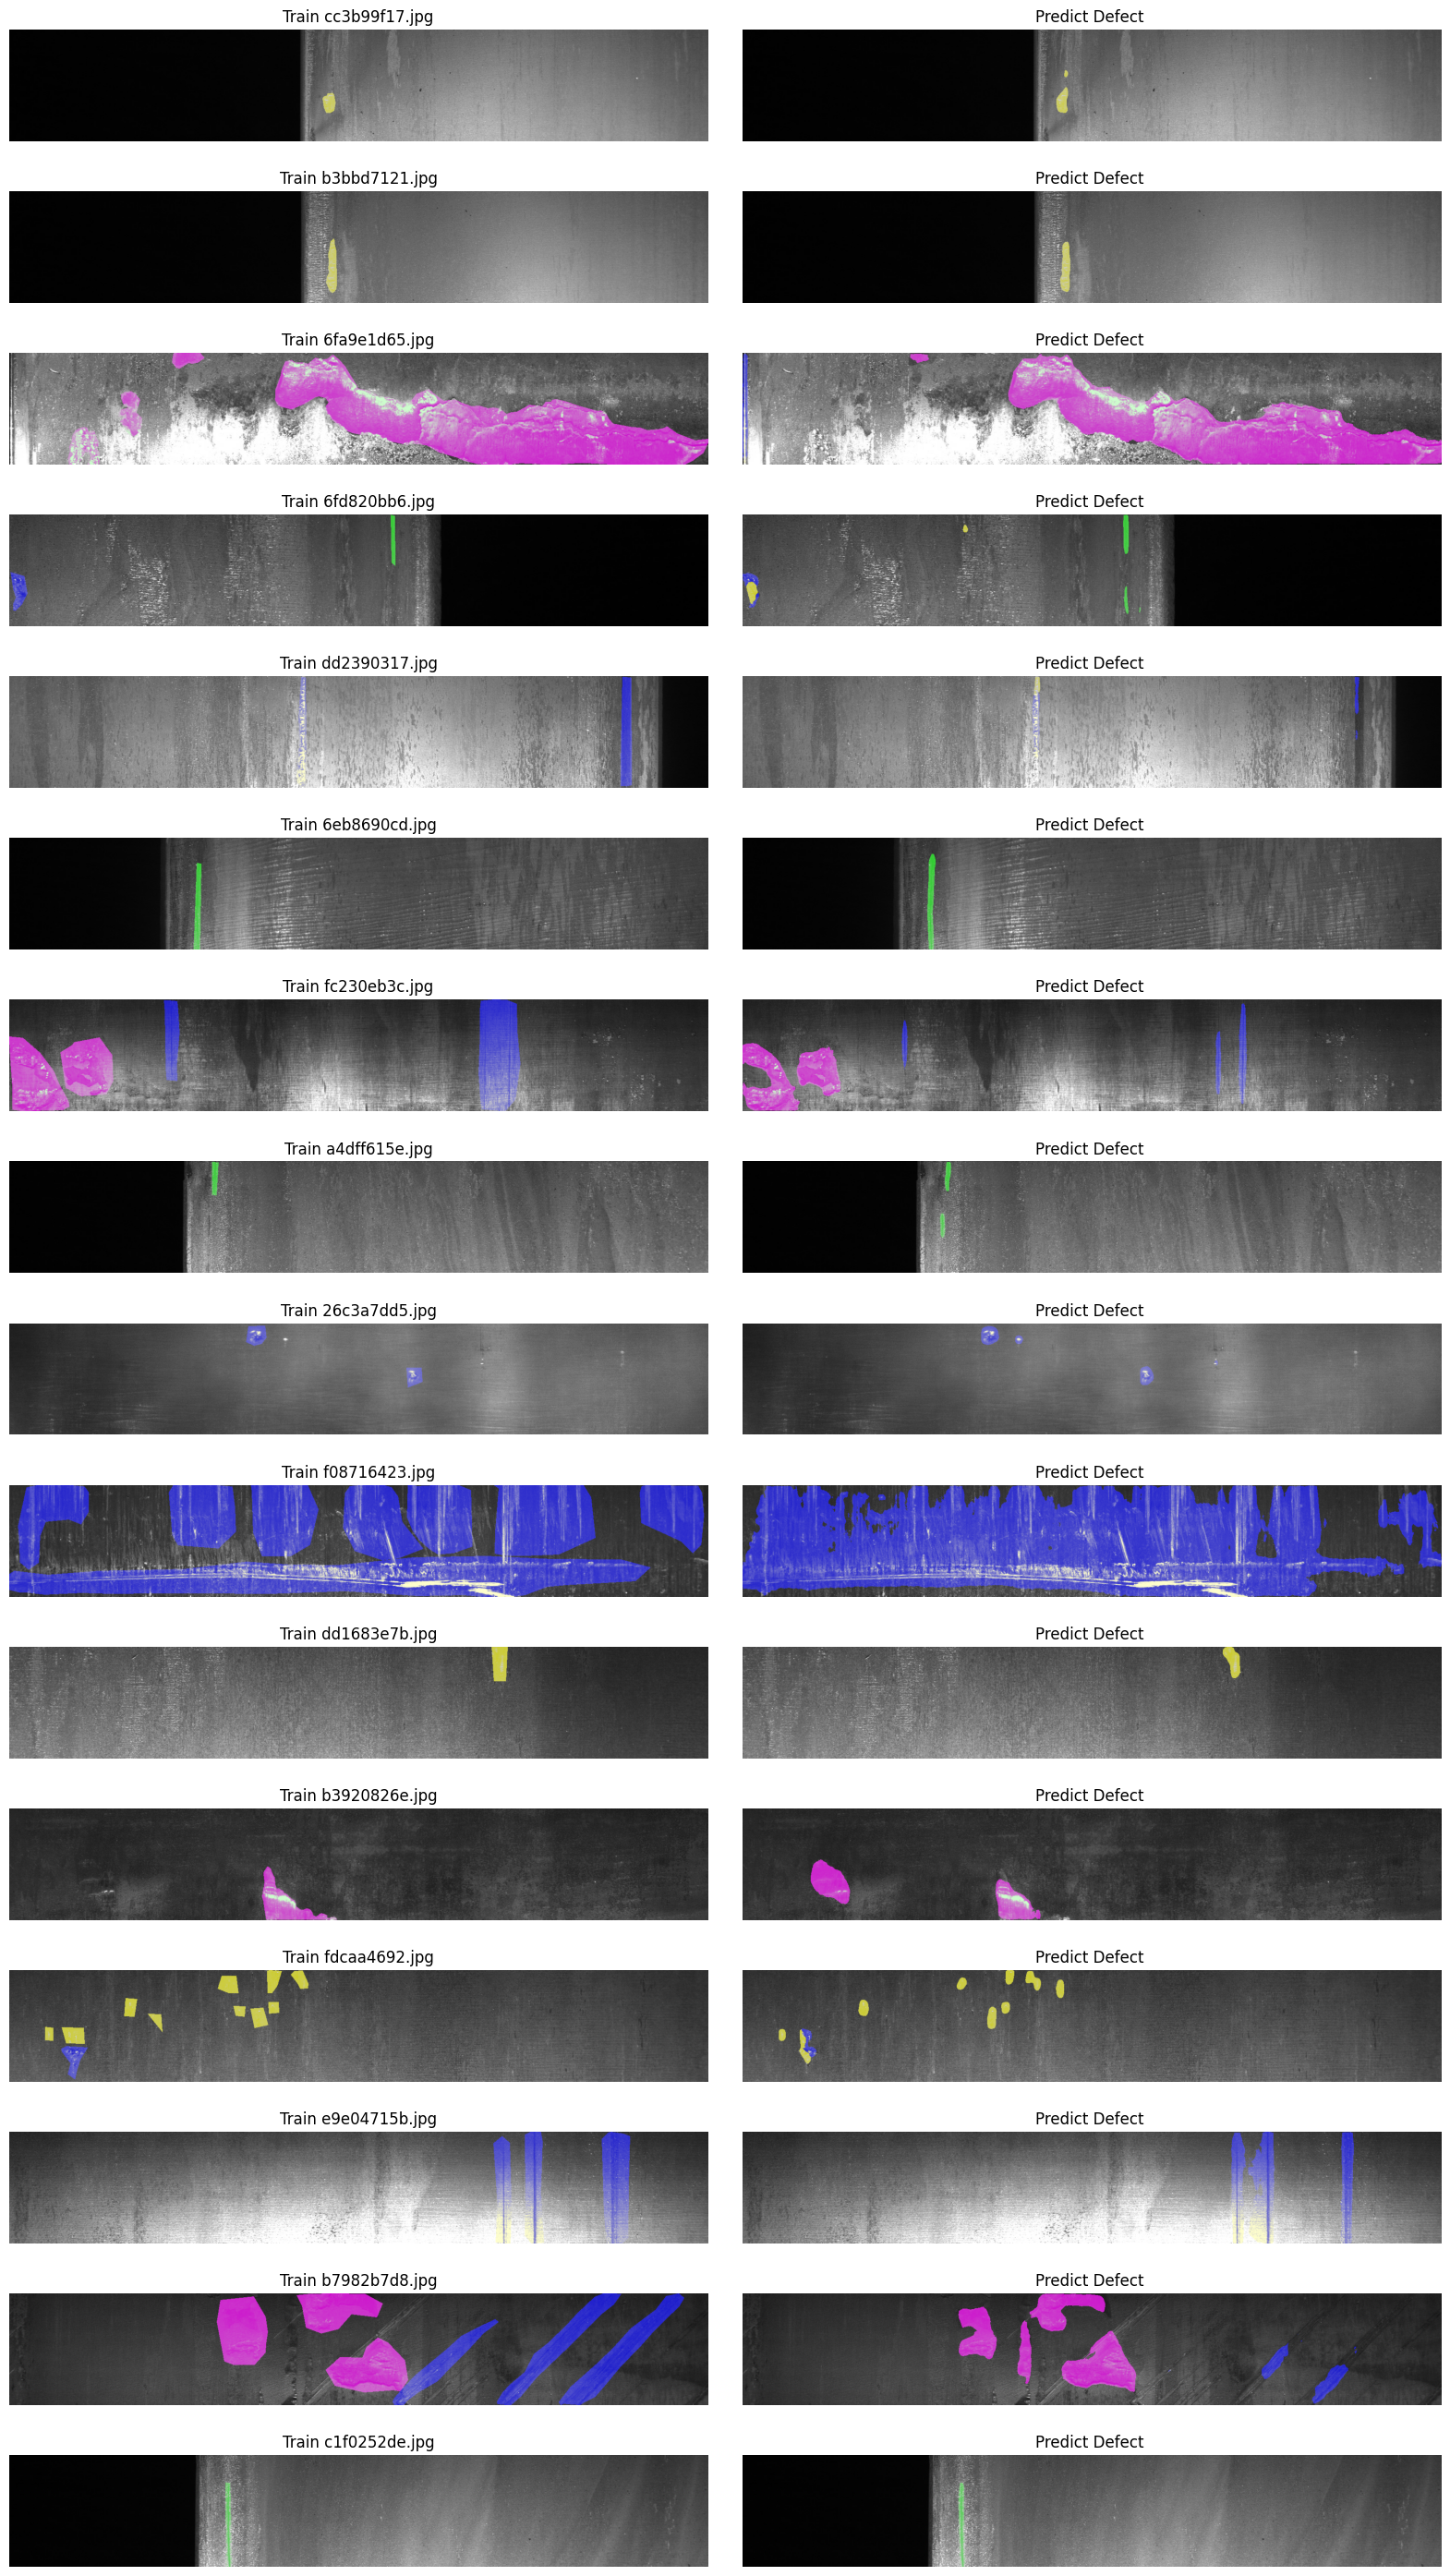

In [ ]:
defects = list(valid_df_seg[valid_df_seg['e1']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e2']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e3']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e4']!=''].sample(4).index)

valid_batches = DataGenerator(valid_df_seg[valid_df_seg.index.isin(defects)], batch_size=16, plot_mode=True, label_sparse=False, normal=False, mask_label_mode='multi')
generate_image_w_mask(valid_batches, unet_model, figure_size=(20,18))

In [ ]:
blockLength = 100
f1_score = F1_score(threshold=None, average=False, task='segment')

for begin in np.arange(0,len(valid_df_seg),blockLength):
  test_batch = DataGenerator(valid_df_seg[begin:begin+blockLength], batch_size=1, plot_mode=True, label_sparse=False, normal=False, mask_label_mode='multi', pixel_half=False)
  predict_result = unet_model.predict(test_batch, verbose=1)
  for idx, true_batch in enumerate(test_batch):
    pred = predict_result[idx]
    pred = pred[np.newaxis,]
    true_batch_squ = np.squeeze(true_batch[1], axis=0)
    f1_score.update_state(y_true=true_batch[1], y_pred=pred)

print('F1score Defect 1: ',f1_score.result().numpy()[1])
print('F1score Defect 2: ',f1_score.result().numpy()[2])
print('F1score Defect 3: ',f1_score.result().numpy()[3])
print('F1score Defect 4: ',f1_score.result().numpy()[4])

67/67 [==============================] - 2s 36ms/step
F1score Defect 1:  0.5999577
F1score Defect 2:  0.57636124
F1score Defect 3:  0.7698122
F1score Defect 4:  0.8297102


## 7.2. PSPNet

In [ ]:
def SpatialContextBlock(
        level,
        num_pool
        ):

  pooling_name = 'psp_level{}_pooling'.format(level)
  conv_block_name = 'psp_level{}'.format(level)
  upsampling_name = 'psp_level{}_upsampling'.format(level)

  def wrapper(input_tensor):
      # extract input feature maps size (h, and w dimensions)
      input_shape = K.int_shape(input_tensor)

      spatial_size = input_shape[1:3] if K.image_data_format() == 'channels_last' else input_shape[2:]
      num_filter = input_shape[3] / num_pool

      # Compute the kernel and stride sizes according to how large the final feature map will be
      # When the kernel factor and strides are equal, then we can compute the final feature map factor
      # by simply dividing the current factor by the kernel or stride factor
      # The final feature map sizes are 1x1, 2x2, 3x3, and 6x6.
      pool_size = up_size = [math.ceil(spatial_size[0] / level), math.ceil(spatial_size[1] / level)]
      # pool_size = up_size = [spatial_size[0] // level, spatial_size[1] // level]

      x = tf.keras.layers.AveragePooling2D(pool_size, strides=pool_size, padding='same', name=pooling_name)(input_tensor)
      x = tf.keras.layers.Conv2D(num_filter, kernel_size=1, kernel_initializer='he_uniform', padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation('relu')(x)
      x = tf.keras.layers.UpSampling2D(up_size, interpolation='bilinear', name=upsampling_name)(x)
      return x

  return wrapper

def build_psp(
        downsample_factor=16,
        image_size = (256,1600,3),
        pool_level = [1,2,4,10],
        use_batchnorm=True,
        final_upsampling_factor=16,
        classes=5,
        activation='softmax',
        dropout=None,
):


    model_input = tf.keras.Input(shape=image_size)
    backbone = tf.keras.applications.EfficientNetB3(include_top=False,
                              weights='imagenet',
                              input_tensor=model_input)
    # backbone = tf.keras.applications.ResNet50(include_top=False,
    #                           weights=None,
    #                           input_tensor=model_input)

    # feature_layers = ['conv4_block6_2_relu', 'conv3_block4_out', 'conv2_block3_out']

    feature_layers = ['block6a_expand_activation', 'block4a_expand_activation', 'block3a_expand_activation']

    if downsample_factor == 16:
        psp_layer_idx = feature_layers[0]
    elif downsample_factor == 8:
        psp_layer_idx = feature_layers[1]
    elif downsample_factor == 4:
        psp_layer_idx = feature_layers[2]
    else:
        raise ValueError('Unsupported factor - `{}`, Use 4, 8 or 16.'.format(downsample_factor))

    x = backbone.get_layer(name=psp_layer_idx).output
    backbone_filter = K.int_shape(x)[3]
    # x = tf.keras.layers.Conv2D(filters=conv_filters, kernel_size=(1,1), kernel_initializer='he_uniform')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Activation('relu')(x)

    spatial_list = []
    spatial_list.append(x)
    # build spatial pyramid
    for i in range(len(pool_level)):
      sp_x = SpatialContextBlock(level=pool_level[i], num_pool=len(pool_level))(x)
      spatial_list.append(sp_x)

    # aggregate spatial pyramid
    concat_axis = 3
    x = tf.keras.layers.Concatenate(axis=concat_axis, name='psp_concat')(spatial_list)
    x = tf.keras.layers.Conv2D(backbone_filter//len(pool_level), kernel_size=1, kernel_initializer='he_uniform', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # model regularization
    if dropout is not None:
        x = tf.keras.layers.Dropout(rate=dropout)(x)

    # model head
    x = tf.keras.layers.Conv2D(
        filters=classes,
        kernel_size=(3, 3),
        padding='same',
        kernel_initializer='glorot_uniform',
        name='final_conv',
        )(x)

    x = tf.keras.layers.UpSampling2D(final_upsampling_factor, name='final_upsampling', interpolation='bilinear')(x)
    x = tf.keras.layers.Activation(activation, name=activation)(x)

    model = tf.keras.models.Model(model_input, x)

    return model

### 7.2.1. Training

In [ ]:
batch_size=5

# train_batches = DataGenerator(crop_df_train[:], subset='train', input_size=(256,256), batch_size=batch_size, data_path='/content/kaggle/train_crop_images/', plot_mode=True, normal=False, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
# valid_batches = DataGenerator(crop_df_val[:], subset='val', input_size=(256,256), batch_size=batch_size, data_path='/content/kaggle/val_crop_images/', plot_mode=True, normal=False, pixel_half=False, label_sparse=False, mask_label_mode='multi')

train_batches = DataGenerator(train_df_seg[:], subset='train', input_size=(256,1600), batch_size=batch_size, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
valid_batches = DataGenerator(valid_df_seg[:], subset='val', input_size=(256,1600), batch_size=batch_size, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, label_sparse=False, mask_label_mode='multi')

steps_per_epoch = len(train_df_seg) // batch_size

clr = CyclicalLearningRate(initial_learning_rate=1e-07,
    maximal_learning_rate=1e-5,
    # scale_fn=lambda x: 1/(2.**(x-1)),
    scale_fn= lambda x: 0.9 ** (x),
    step_size=2 * steps_per_epoch,

)

adam = tf.keras.optimizers.Adam(learning_rate=clr)
adamW = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-03, weight_decay=0.000001)
sgd = tf.keras.optimizers.SGD(learning_rate=5e-05, momentum=0.9, weight_decay=0.00001)

tcl = TverskyCCELoss(CCE_weights=0.6, tversky_weights=0.4, alpha=0.7) # Tversky = (TP + smooth) / (TP + (1-alpha)*FP + (alpha)*FN + smooth)
ftcl = FocalTversky_CCELoss(CCE_weights=0.6, focal_tversky_weights=0.4, alpha=0.3, gamma=2.0, class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])
wcce = weighted_categoricalCE_loss(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])

pspnet_model = build_psp(downsample_factor=16, image_size=(256,1600,3), final_upsampling_factor=16, classes=5, activation='softmax', dropout=0.2,)

for layer in pspnet_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

pspnet_model.compile(optimizer=adam,
                loss = ftcl,
                metrics=[F1_score(threshold=None, average=True, ignore_ground=True, task='segment', num_classes=5)])

In [ ]:
pspnet_model.summary()

In [ ]:
pspnet_model.load_weights('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/PSPnet_fcal_b3_2.hdf5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

checkpoint_filepath = '/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/PSPnet_fcal_b3_2_full.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=True)

reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode='min',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,)

log_csv = CSVLogger('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/FPN_EfficientNet_cce-dice_cw_aug4_crop256-416_radam-b4_GA/log_PSPnet_fcal_b3_2_full.csv', separator=',', append=False)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10 , mode = 'min')

In [ ]:
epochs = 20

class Get_Lr(tf.keras.callbacks.Callback):
  def __init__(self, optimizer):
    self.lrs = []
    self.optimizer = optimizer

  def on_epoch_end(self, epoch, logs=None):
      logs = logs or {}
      logs["lr"] = K.get_value(self.model.optimizer.lr)

get_lr = Get_Lr(pspnet_model.optimizer)

callback_list = [log_csv, model_checkpoint_callback, es, get_lr]

history = pspnet_model.fit(train_batches, validation_data = valid_batches, epochs=epochs ,verbose=1, callbacks=callback_list)

Epoch 1/20
1199/1199 [==============================] - 472s 364ms/step - loss: 0.3294 - F1_score: 0.6523 - val_loss: 0.3079 - val_F1_score: 0.6501 - lr: 1.9793e-06
Epoch 2/20
1199/1199 [==============================] - 398s 332ms/step - loss: 0.3159 - F1_score: 0.6933 - val_loss: 0.3053 - val_F1_score: 0.6701 - lr: 3.8601e-06
Epoch 3/20
1199/1199 [==============================] - 399s 333ms/step - loss: 0.3142 - F1_score: 0.7033 - val_loss: 0.3038 - val_F1_score: 0.6799 - lr: 5.7409e-06
Epoch 4/20
1199/1199 [==============================] - 404s 337ms/step - loss: 0.3151 - F1_score: 0.7125 - val_loss: 0.3032 - val_F1_score: 0.6776 - lr: 7.6217e-06
Epoch 5/20
1199/1199 [==============================] - 453s 378ms/step - loss: 0.3113 - F1_score: 0.7155 - val_loss: 0.3036 - val_F1_score: 0.6880 - lr: 8.5174e-06
Epoch 6/20
1199/1199 [==============================] - 407s 340ms/step - loss: 0.3086 - F1_score: 0.7217 - val_loss: 0.3042 - val_F1_score: 0.6863 - lr: 6.6366e-06
Epoch 7/20

### 7.2.2. Evaluating

Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4
2/2 [==============================] - 6s 94ms/step


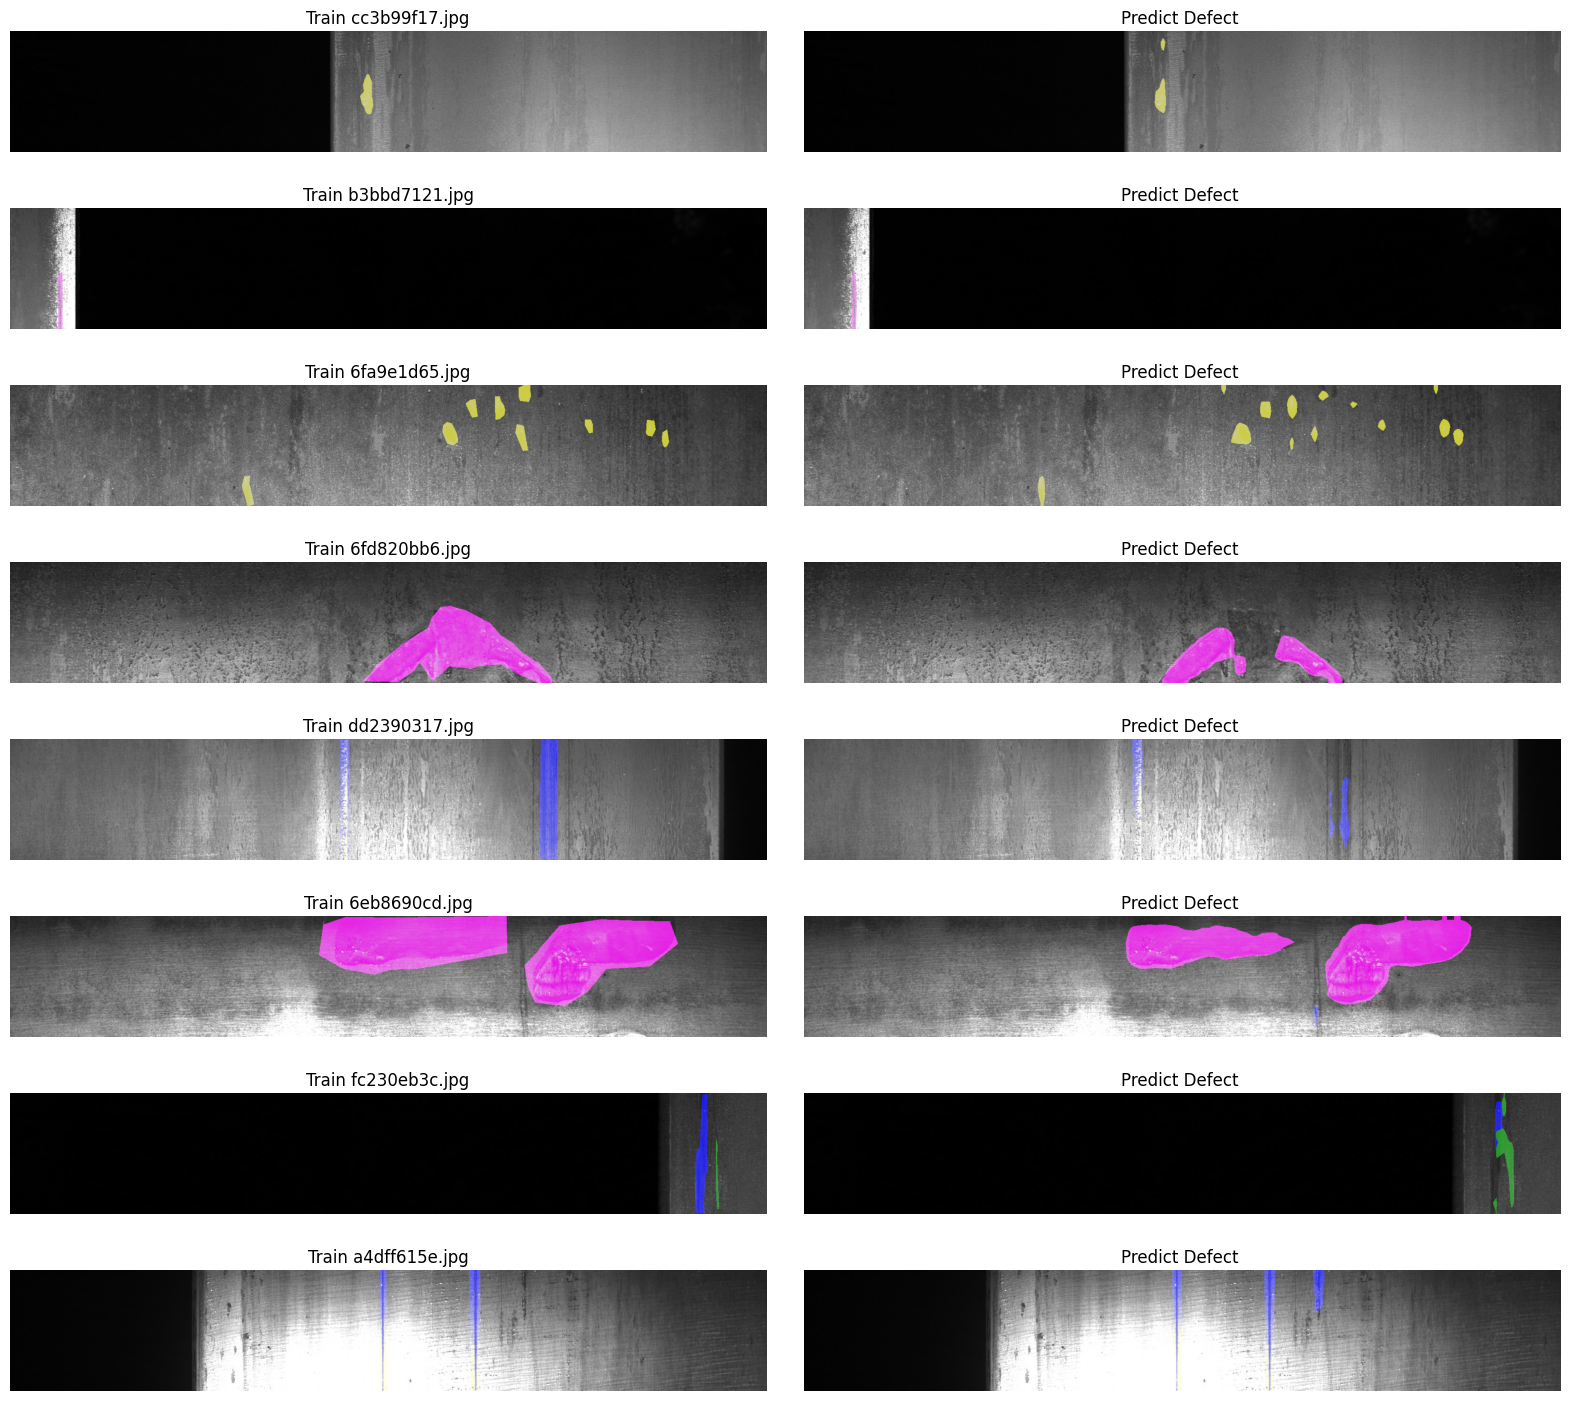

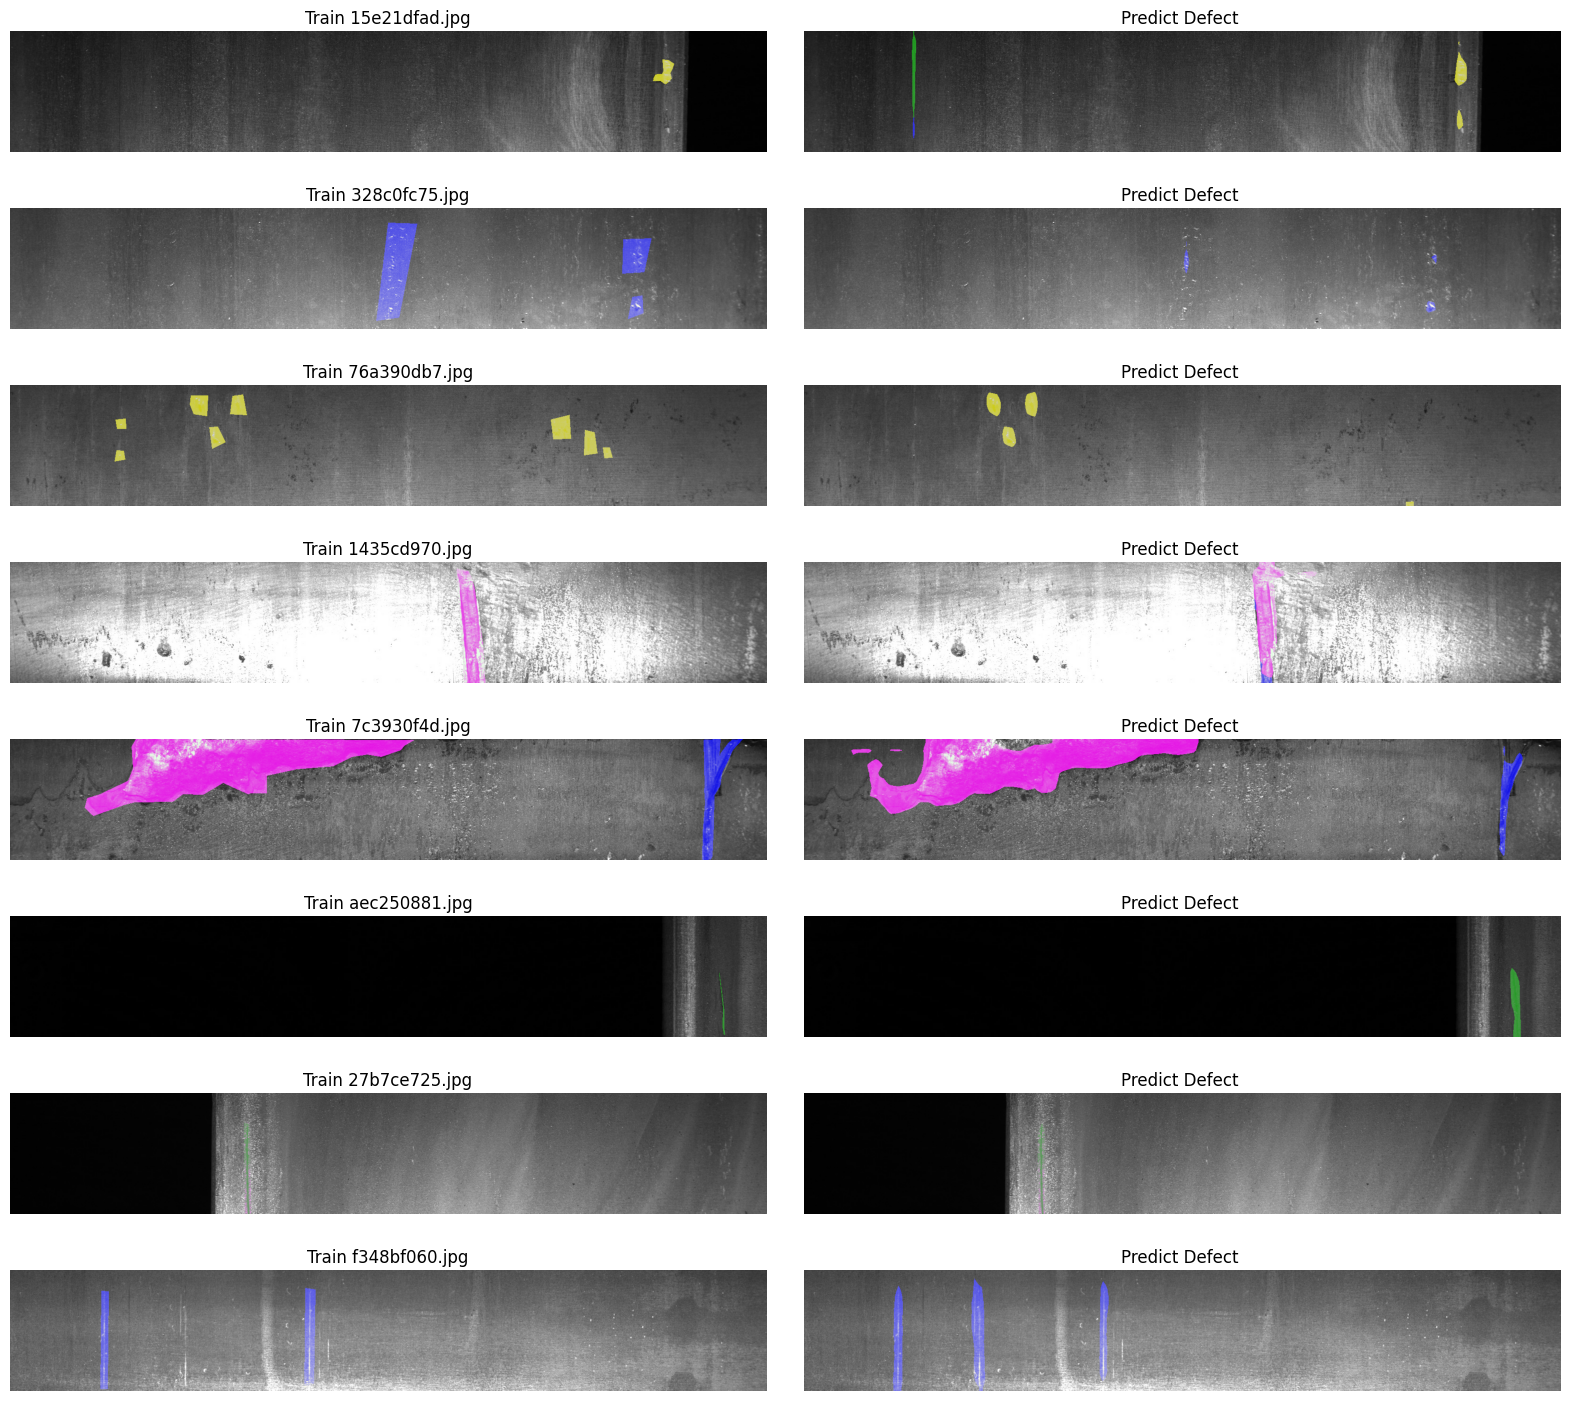

In [ ]:
from skimage.morphology import remove_small_objects

defects = list(valid_df_seg[valid_df_seg['e1']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e2']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e3']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e4']!=''].sample(4).index)

valid_batches = DataGenerator(valid_df_seg[valid_df_seg.index.isin(defects)], batch_size=8, plot_mode=True, label_sparse=False, normal=False, mask_label_mode='multi')

generate_image_w_mask(valid_batches, pspnet_model, figure_size=(20,18))

In [ ]:
blockLength = 100
f1_score = F1_score(threshold=None, average=False, task='segment')

for begin in np.arange(0,len(valid_df_seg),blockLength):
  test_batch = DataGenerator(valid_df_seg[begin:begin+blockLength], batch_size=1, plot_mode=True, label_sparse=False, normal=False, mask_label_mode='multi', pixel_half=False)
  predict_result = pspnet_model.predict(test_batch, verbose=1)
  for idx, true_batch in enumerate(test_batch):
    pred = predict_result[idx]
    pred = pred[np.newaxis,]
    true_batch_squ = np.squeeze(true_batch[1], axis=0)
    f1_score.update_state(y_true=true_batch[1], y_pred=pred)

print('F1score Defect 1: ',f1_score.result().numpy()[1])
print('F1score Defect 2: ',f1_score.result().numpy()[2])
print('F1score Defect 3: ',f1_score.result().numpy()[3])
print('F1score Defect 4: ',f1_score.result().numpy()[4])

67/67 [==============================] - 3s 50ms/step
F1score Defect 1:  0.60527307
F1score Defect 2:  0.5731155
F1score Defect 3:  0.7707061
F1score Defect 4:  0.8280015


## 7.3.DeeplabV3 plus

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tf.keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes, activation='softmax'):
    model_input = tf.keras.Input(shape=image_size)
    EfficientNet = tf.keras.applications.EfficientNetB3(
        weights="imagenet", include_top=False, input_tensor=model_input
    )

    x = EfficientNet.get_layer("block6a_expand_activation").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = tf.keras.layers.UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = EfficientNet.get_layer("block3a_expand_activation").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation=activation)(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
batch_size=5

# train_batches = DataGenerator(crop_df_train[:], subset='train', input_size=(256,1600), batch_size=batch_size, data_path='/content/kaggle/train_crop_images/', plot_mode=True, normal=False, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
# valid_batches = DataGenerator(crop_df_val[:], subset='val', input_size=(256,1600), batch_size=batch_size, data_path='/content/kaggle/val_crop_images/', plot_mode=True, normal=False, pixel_half=False, label_sparse=False, mask_label_mode='multi')

train_batches = DataGenerator(train_df_seg[:], subset='train', input_size=(256,1600), batch_size=batch_size, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
valid_batches = DataGenerator(valid_df_seg[:], subset='val', input_size=(256,1600), batch_size=batch_size, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, label_sparse=False, mask_label_mode='multi')

steps_per_epoch = len(train_df_seg) // batch_size

clr = CyclicalLearningRate(initial_learning_rate=1e-07,
    maximal_learning_rate=1e-5,
    # scale_fn=lambda x: 1/(2.**(x-1)),
    scale_fn= lambda x: 0.9 ** (x),
    step_size=2 * steps_per_epoch,

)

adam = tf.keras.optimizers.Adam(learning_rate=clr)
adamW = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-03, weight_decay=0.000001)
sgd = tf.keras.optimizers.SGD(learning_rate=5e-05, momentum=0.9, weight_decay=0.00001)

tcl = TverskyCCELoss(CCE_weights=0.6, tversky_weights=0.4, alpha=0.7) # Tversky = (TP + smooth) / (TP + (1-alpha)*FP + (alpha)*FN + smooth)
ftcl = FocalTversky_CCELoss(CCE_weights=0.6, focal_tversky_weights=0.4, alpha=0.3, gamma=2.0, class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])
wcce = weighted_categoricalCE_loss(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])

DeeplabV3 = DeeplabV3Plus(image_size=(256,1600,3), num_classes=5, activation='softmax')

for layer in DeeplabV3.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

DeeplabV3.compile(optimizer=adam,
                loss = ftcl,
                metrics=[F1_score(threshold=None, average=True, ignore_ground=True, task='segment', num_classes=5)])

In [ ]:
DeeplabV3.load_weights('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/DeeplabV3_ftcl_8.2_full_2.hdf5')

In [ ]:
DeeplabV3.summary()

### 7.3.1. Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

checkpoint_filepath = '/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/DeeplabV3_ftcl_8.2_full_2.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=True)



log_csv = CSVLogger('/content/gdrive/MyDrive/project/kaggle/Severstal_Steel Defect Detection_/FPN_EfficientNet_cce-dice_cw_aug4_crop256-416_radam-b4_GA/log_DeeplabV3_ftcl_8.2_full_2.csv', separator=',', append=False)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10 , mode = 'min')

In [ ]:
epochs = 10

class Get_Lr(tf.keras.callbacks.Callback):
  def __init__(self, optimizer):
    self.lrs = []
    self.optimizer = optimizer

  def on_epoch_end(self, epoch, logs=None):
      logs = logs or {}
      logs["lr"] = K.get_value(self.model.optimizer.lr)

get_lr = Get_Lr(DeeplabV3.optimizer)

callback_list = [log_csv, model_checkpoint_callback, es, get_lr]

history = DeeplabV3.fit(train_batches, validation_data = valid_batches, epochs=epochs ,verbose=1, callbacks=callback_list)

Epoch 1/10
1199/1199 [==============================] - 490s 377ms/step - loss: 0.2994 - F1_score: 0.7621 - val_loss: 0.2956 - val_F1_score: 0.7119 - lr: 4.5513e-06
Epoch 2/10
1199/1199 [==============================] - 438s 365ms/step - loss: 0.3001 - F1_score: 0.7619 - val_loss: 0.2951 - val_F1_score: 0.7147 - lr: 9.0063e-06
Epoch 3/10
1199/1199 [==============================] - 449s 374ms/step - loss: 0.3032 - F1_score: 0.7638 - val_loss: 0.2950 - val_F1_score: 0.7177 - lr: 4.5587e-06
Epoch 4/10
1199/1199 [==============================] - 441s 368ms/step - loss: 0.2989 - F1_score: 0.7671 - val_loss: 0.2947 - val_F1_score: 0.7169 - lr: 1.0372e-07
Epoch 5/10
1199/1199 [==============================] - 436s 363ms/step - loss: 0.3008 - F1_score: 0.7673 - val_loss: 0.2946 - val_F1_score: 0.7156 - lr: 4.1062e-06
Epoch 6/10
1199/1199 [==============================] - 445s 371ms/step - loss: 0.3022 - F1_score: 0.7646 - val_loss: 0.2946 - val_F1_score: 0.7172 - lr: 8.1157e-06
Epoch 7/10

### 7.3.2.Evaluating

Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4
2/2 [==============================] - 3s 39ms/step


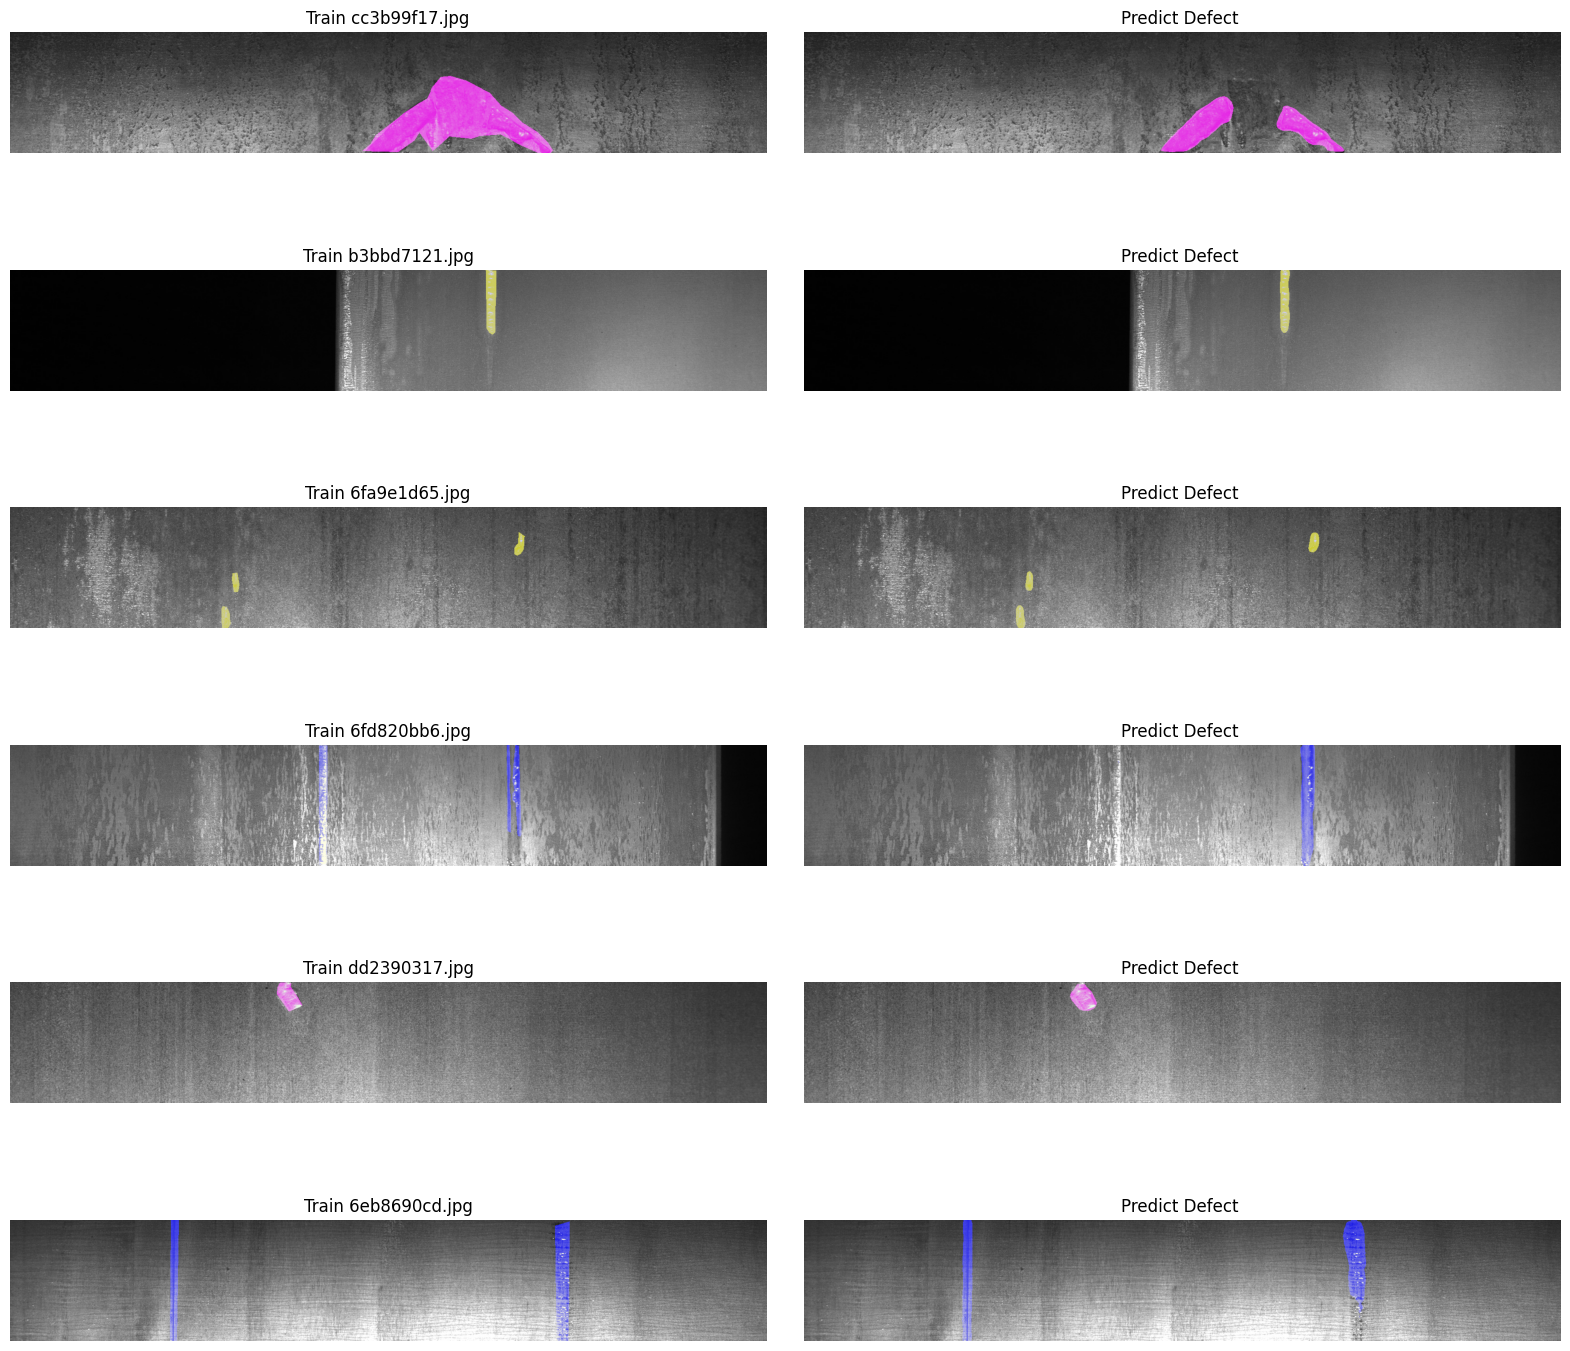

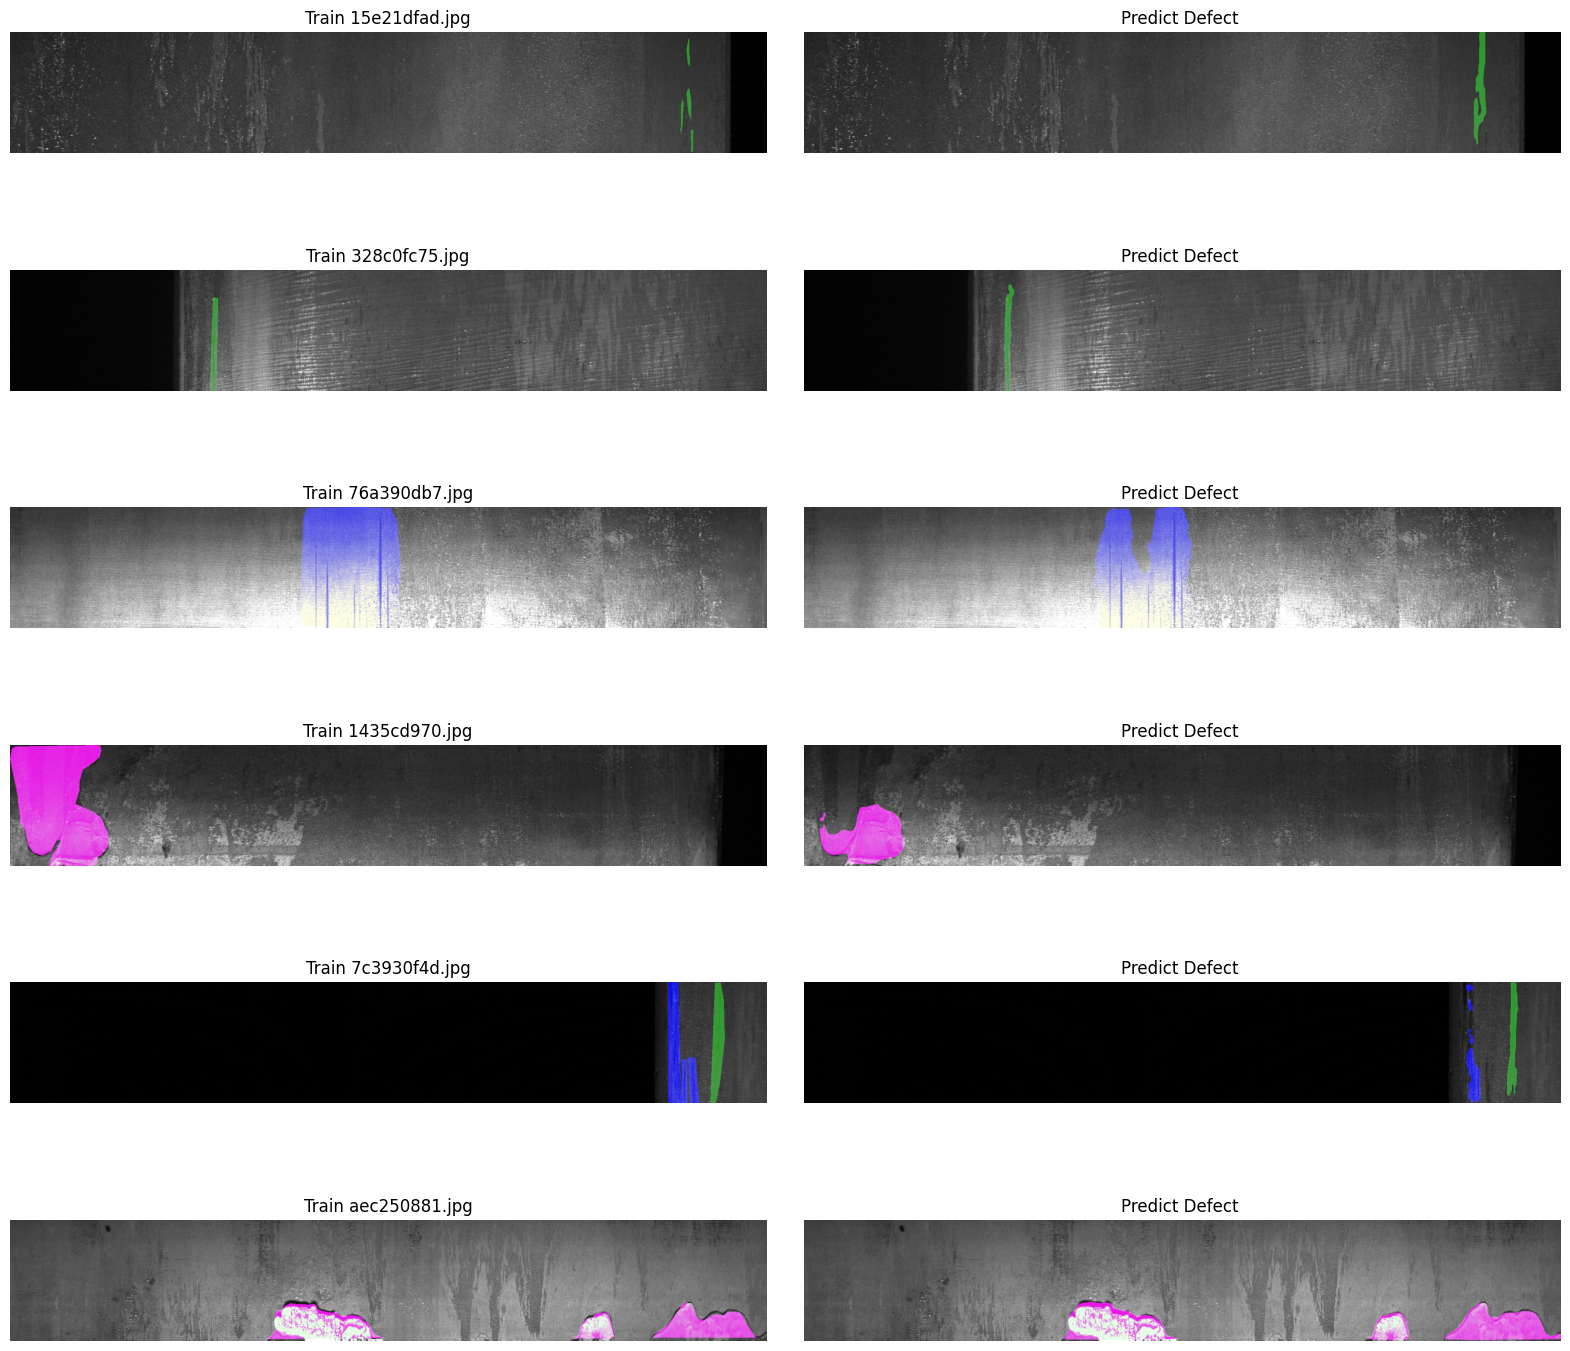

In [ ]:
defects = list(valid_df_seg[valid_df_seg['e1']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e2']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e3']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e4']!=''].sample(4).index)

valid_batches = DataGenerator(valid_df_seg[valid_df_seg.index.isin(defects)], batch_size=6, plot_mode=True, label_sparse=False, normal=False, mask_label_mode='multi')

generate_image_w_mask(valid_batches, DeeplabV3, figure_size=(20,18))

In [ ]:
blockLength = 100
f1_score = F1_score(threshold=None, average=False, task='segment')

for begin in np.arange(0,len(valid_df_seg),blockLength):
  test_batch = DataGenerator(valid_df_seg[begin:begin+blockLength], batch_size=1, plot_mode=True, label_sparse=False, normal=False, mask_label_mode='multi', pixel_half=False)
  predict_result = DeeplabV3.predict(test_batch, verbose=1)
  for idx, true_batch in enumerate(test_batch):
    pred = predict_result[idx]
    pred = pred[np.newaxis,]
    true_batch_squ = np.squeeze(true_batch[1], axis=0)
    f1_score.update_state(y_true=true_batch[1], y_pred=pred)

print('F1score Defect 1: ',f1_score.result().numpy()[1])
print('F1score Defect 2: ',f1_score.result().numpy()[2])
print('F1score Defect 3: ',f1_score.result().numpy()[3])
print('F1score Defect 4: ',f1_score.result().numpy()[4])

67/67 [==============================] - 4s 52ms/step
F1score Defect 1:  0.6310708
F1score Defect 2:  0.62686074
F1score Defect 3:  0.7850704
F1score Defect 4:  0.8319681


## 7.4 DDRnet

In [ ]:
def conv3x3(out_planes, stride=1):
    """
    creates a 3*3 conv with given filters and stride
    :param out_planes:
    :param stride:
    :return:
    """
    return layers.Conv2D(kernel_size=(3, 3), filters=out_planes, strides=stride, padding="same",
                         use_bias=False)


basicblock_expansion = 1
bottleneck_expansion = 2


def basic_block(x_in, planes, stride=1, downsample=None, no_relu=False):
    """
    Creates a residual block with two 3*3 conv's in paper it's represented by RB block
    :param x_in:
    :param planes:
    :param stride:
    :param downsample:
    :param no_relu:
    :return:
    """
    residual = x_in

    x = conv3x3(planes, stride)(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = conv3x3(planes, )(x)
    x = layers.BatchNormalization()(x)

    if downsample is not None:
        residual = downsample

    # x += residual
    x = layers.Add()([x, residual])

    if not no_relu:
        x = layers.Activation("relu")(x)

    return x


def bottleneck_block(x_in, planes, stride=1, downsample=None, no_relu=True):
    """
    creates a bottleneck block of 1*1 -> 3*3 -> 1*1
    :param x_in:
    :param planes:
    :param stride:
    :param downsample:
    :param no_relu:
    :return:
    """
    residual = x_in

    x = layers.Conv2D(filters=planes, kernel_size=(1, 1), use_bias=False)(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters=planes, kernel_size=(3, 3), strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters=planes * bottleneck_expansion, kernel_size=(1, 1), use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample is not None:
        residual = downsample

    # x += residual
    x = layers.Add()([x, residual])

    if not no_relu:
        x = layers.Activation("relu")(x)

    return x


def make_layer(x_in, block, inplanes, planes, blocks_num, stride=1, expansion=1):
    """
    apply multiple RB or RBB blocks.
    :param x_in: input tensor
    :param block: block to apply it can be RB or RBB
    :param inplanes: input tensor channes
    :param planes: output tensor channels
    :param blocks_num: number of time block to applied
    :param stride: stride
    :param expansion: expand last dimension
    :return:
    """
    downsample = None
    if stride != 1 or inplanes != planes * expansion:
        downsample = layers.Conv2D(((planes * expansion)), kernel_size=(1, 1), strides=stride, use_bias=False)(x_in)
        downsample = layers.BatchNormalization()(downsample)
        downsample = layers.Activation("relu")(downsample)

    x = block(x_in, planes, stride, downsample)
    for i in range(1, blocks_num):
        if i == (blocks_num - 1):
            x = block(x, planes, stride=1, no_relu=True)
        else:
            x = block(x, planes, stride=1, no_relu=False)

    return x

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

def DAPPPM(x_in, branch_planes, outplanes):
    """
    Deep Aggregation Pyramid Pooling Module
    :param x_in:
    :param branch_planes:
    :param outplanes:
    :return:
    """
    input_shape = tf.keras.backend.int_shape(x_in)

    height = input_shape[1]
    width = input_shape[2]
    # Average pooling kernel size
    kernal_sizes_height = [5, 9, 17, height]
    kernal_sizes_width = [5, 9, 17, width]
    # Average pooling strides size
    stride_sizes_height = [2, 4, 8, height]
    stride_sizes_width = [2, 4, 8, width]
    x_list = []

    # y1
    scale0 = layers.BatchNormalization()(x_in)
    scale0 = layers.Activation("relu")(scale0)
    scale0 = layers.Conv2D(branch_planes, kernel_size=(1, 1), use_bias=False, )(scale0)
    x_list.append(scale0)

    for i in range(len(kernal_sizes_height)):
        # first apply average pooling
        temp = layers.AveragePooling2D(pool_size=(kernal_sizes_height[i], kernal_sizes_width[i]),
                                       strides=(stride_sizes_height[i], stride_sizes_width[i]),
                                       padding="same")(x_in)
        temp = layers.BatchNormalization()(temp)
        temp = layers.Activation("relu")(temp)
        # then apply 1*1 conv
        temp = layers.Conv2D(branch_planes, kernel_size=(1, 1), use_bias=False, )(temp)
        # then resize using bilinear
        temp = tf.image.resize(temp, size=(height, width), )
        # add current and previous layer output
        temp = layers.Add()([temp, x_list[i]])
        temp = layers.BatchNormalization()(temp)
        temp = layers.Activation("relu")(temp)
        # at the end apply 3*3 conv
        temp = layers.Conv2D(branch_planes, kernel_size=(3, 3), use_bias=False, padding="same")(temp)
        # y[i+1]
        x_list.append(temp)

    # concatenate all
    combined = layers.concatenate(x_list, axis=-1)

    combined = layers.BatchNormalization()(combined)
    combined = layers.Activation("relu")(combined)
    combined = layers.Conv2D(outplanes, kernel_size=(1, 1), use_bias=False, )(combined)

    shortcut = layers.BatchNormalization()(x_in)
    shortcut = layers.Activation("relu")(shortcut)
    shortcut = layers.Conv2D(outplanes, kernel_size=(1, 1), use_bias=False, )(shortcut)

    # final = combined + shortcut
    final = layers.Add()([combined, shortcut])

    return final


def segmentation_head(x_in, interplanes, outplanes, scale_factor=None):
    """
    Segmentation head
    3*3 -> 1*1 -> rescale
    :param x_in:
    :param interplanes:
    :param outplanes:
    :param scale_factor:
    :return:
    """
    x = layers.BatchNormalization()(x_in)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(interplanes, kernel_size=(3, 3), use_bias=False, padding="same")(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(outplanes, kernel_size=(1, 1), use_bias=range, padding="valid")(x)

    if scale_factor is not None:
        input_shape = tf.keras.backend.int_shape(x)
        height2 = input_shape[1] * scale_factor
        width2 = input_shape[2] * scale_factor
        x = tf.image.resize(x, size=(height2, width2))

    return x


def ddrnet(input_shape=[256, 1600, 3], layers_arg=[2, 2, 2, 2], num_classes=5, planes=32, spp_planes=128,
                   head_planes=64, scale_factor=8, augment=False):
    """
    ddrnet 23 slim
    :param input_shape: shape of input data
    :param layers_arg: how many times each Rb block is repeated
    :param num_classes: output classes
    :param planes: filter size kept throughout model
    :param spp_planes: DAPPM block output dimensions
    :param head_planes: segmentation head dimensions
    :param scale_factor: scale output factor
    :param augment: whether auxiliary loss is added or not
    :return:
    """

    x_in = layers.Input(input_shape)
    x = layers.Rescaling(1.0 / 255.0)(x_in)
    # x = layers.Normalization()(x)

    highres_planes = planes * 2
    input_shape = tf.keras.backend.int_shape(x_in)
    height_output = input_shape[1] // 8
    width_output = input_shape[2] // 8

    layers_inside = []

    # 1 -> 1/2 first conv layer
    x = layers.Conv2D(planes, kernel_size=(3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # 1/2 -> 1/4 second conv layer
    x = layers.Conv2D(planes, kernel_size=(3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # layer 1
    # 1/4 -> 1/4 first basic residual block not mentioned in the image
    x = make_layer(x, basic_block, planes, planes, layers_arg[0], expansion=basicblock_expansion)
    layers_inside.append(x)

    # layer 2
    # 2 High :: 1/4 -> 1/8 storing results at index:1
    x = layers.Activation("relu")(x)
    x = make_layer(x, basic_block, planes, planes * 2, layers_arg[1], stride=2, expansion=basicblock_expansion)
    layers_inside.append(x)

    """
    For next layers
    x:  low branch
    x_: high branch
    """

    # layer 3
    # 3 Low :: 1/8 -> 1/16 storing results at index:2
    x = layers.Activation("relu")(x)
    x = make_layer(x, basic_block, planes * 2, planes * 4, layers_arg[2], stride=2, expansion=basicblock_expansion)
    layers_inside.append(x)
    # 3 High :: 1/8 -> 1/8 retrieving from index:1
    x_ = layers.Activation("relu")(layers_inside[1])
    x_ = make_layer(x_, basic_block, planes * 2, highres_planes, 2, expansion=basicblock_expansion)

    # Fusion 1
    # x -> 1/16 to 1/8, x_ -> 1/8 to 1/16
    # High to Low
    x_temp = layers.Activation("relu")(x_)
    x_temp = layers.Conv2D(planes * 4, kernel_size=(3, 3), strides=2, padding='same', use_bias=False)(x_temp)
    x_temp = layers.BatchNormalization()(x_temp)
    x = layers.Add()([x, x_temp])
    # Low to High
    x_temp = layers.Activation("relu")(layers_inside[2])
    x_temp = layers.Conv2D(highres_planes, kernel_size=(1, 1), use_bias=False)(x_temp)
    x_temp = layers.BatchNormalization()(x_temp)
    x_temp = tf.image.resize(x_temp, (height_output, width_output))  # 1/16 -> 1/8
    x_ = layers.Add()([x_, x_temp])  # next high branch input, 1/8

    if augment:
        temp_output = x_  # Auxiliary loss from high branch

    # layer 4
    # 4 Low :: 1/16 -> 1/32 storing results at index:3
    x = layers.Activation("relu")(x)
    x = make_layer(x, basic_block, planes * 4, planes * 8, layers_arg[3], stride=2, expansion=basicblock_expansion)
    layers_inside.append(x)
    # 4 High :: 1/8 -> 1/8
    x_ = layers.Activation("relu")(x_)
    x_ = make_layer(x_, basic_block, highres_planes, highres_planes, 2, expansion=basicblock_expansion)

    # Fusion 2 :: x_ -> 1/32 to 1/8, x -> 1/8 to 1/32 using two conv's
    # High to low
    x_temp = layers.Activation("relu")(x_)
    x_temp = layers.Conv2D(planes * 4, kernel_size=(3, 3), strides=2, padding='same', use_bias=False)(x_temp)
    x_temp = layers.BatchNormalization()(x_temp)
    x_temp = layers.Activation("relu")(x_temp)
    x_temp = layers.Conv2D(planes * 8, kernel_size=(3, 3), strides=2, padding='same', use_bias=False)(x_temp)
    x_temp = layers.BatchNormalization()(x_temp)
    x = layers.Add()([x, x_temp])
    # Low to High
    x_temp = layers.Activation("relu")(layers_inside[3])
    x_temp = layers.Conv2D(highres_planes, kernel_size=(1, 1), use_bias=False)(x_temp)
    x_temp = layers.BatchNormalization()(x_temp)
    x_temp = tf.image.resize(x_temp, (height_output, width_output))
    x_ = layers.Add()([x_, x_temp])

    # layer 5
    # 5 High :: 1/8 -> 1/8
    x_ = layers.Activation("relu")(x_)
    x_ = make_layer(x_, bottleneck_block, highres_planes, highres_planes, 1, expansion=bottleneck_expansion)
    x = layers.Activation("relu")(x)
    # 5 Low :: 1/32 -> 1/64
    x = make_layer(x, bottleneck_block, planes * 8, planes * 8, 1, stride=2, expansion=bottleneck_expansion)

    # Deep Aggregation Pyramid Pooling Module
    x = DAPPPM(x, spp_planes, planes * 4)

    # resize from 1/64 to 1/8
    x = tf.image.resize(x, (height_output, width_output))

    x_ = layers.Add()([x, x_])

    x_ = segmentation_head((x_), head_planes, num_classes, scale_factor)

    # apply softmax at the output layer
    x_ = tf.nn.softmax(x_)

    if augment:
        x_extra = segmentation_head(temp_output, head_planes, num_classes, scale_factor)  # without scaling
        x_extra = tf.nn.softmax(x_extra)
        model_output = [x_, x_extra]
    else:
        model_output = x_

    model = models.Model(inputs=[x_in], outputs=[model_output])

    # set weight initializers
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel_initializer = tf.keras.initializers.he_normal()
        if hasattr(layer, 'depthwise_initializer'):
            layer.depthwise_initializer = tf.keras.initializers.he_normal()

    return model

### 7.4.1. Training

In [ ]:
batch_size=8
# train_batches = DataGenerator(crop_df_train[:], subset='train', input_size=(256,256), batch_size=batch_size, data_path='/content/kaggle/train_crop_images/', plot_mode=True, normal=False, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
# valid_batches = DataGenerator(crop_df_val[:], subset='val', input_size=(256,256), batch_size=batch_size, data_path='/content/kaggle/val_crop_images/', plot_mode=True, normal=False, pixel_half=False, label_sparse=False, mask_label_mode='multi')
train_batches = DataGenerator(train_df_seg[:], subset='train', input_size=(256,1600), batch_size=batch_size, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, shuffle=True, augment_transform=augmentations, label_sparse=False, mask_label_mode='multi')
valid_batches = DataGenerator(valid_df_seg[:], subset='val', input_size=(256,1600), batch_size=batch_size, data_path='/content/kaggle/train_images/', plot_mode=True, normal=False, pixel_half=False, label_sparse=False, mask_label_mode='multi')

steps_per_epoch = len(crop_df_train) // batch_size

clr = CyclicalLearningRate(initial_learning_rate=1e-06,
    maximal_learning_rate=1e-4,
    scale_fn= lambda x: 0.8 ** (x),
    step_size=2 * steps_per_epoch,

)

adam = tf.keras.optimizers.Adam(learning_rate=clr)
adamW = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-05, weight_decay=0.00001)
sgd = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, weight_decay=0.00001)

tcl = TverskyCCELoss(CCE_weights=0.6, tversky_weights=0.4, alpha=0.7, class_weights=[1.0, 2.0, 2.0, 1.0, 1.5]) # Tversky = (TP + smooth) / (TP + (1-alpha)*FP + (alpha)*FN + smooth)
ftcl = FocalTversky_CCELoss(CCE_weights=0.5, focal_tversky_weights=0.5, alpha=0.3, gamma=2.0, class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])
wcce = weighted_categoricalCE_loss(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5])
dice_wcce =  DiceCCELoss(class_weights=[1.0, 2.0, 2.0, 1.0, 1.5], CCE_weights=0.5, Dice_weights=0.5)

ddrnet23 = ddrnet(num_classes=5, input_shape=(256,1600,3), layers_arg=[2, 2, 2, 2],
                  planes=40, spp_planes=128,
                   head_planes=256, scale_factor=8, augment=False)

for layer in ddrnet23.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

ddrnet23.compile(optimizer=adamW,
                loss = wcce,
                metrics=[F1_score(threshold=None, average=True, ignore_ground=True, task='segment', num_classes=5)],
                )

### 7.4.2. Evaluating

In [ ]:
defects = list(valid_df_seg[valid_df_seg['e1']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e2']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e3']!=''].sample(4).index)
defects += list(valid_df_seg[valid_df_seg['e4']!=''].sample(4).index)

valid_batches = DataGenerator(valid_df_seg[valid_df_seg.index.isin(defects)], batch_size=6, plot_mode=True, label_sparse=False, normal=False, mask_label_mode='multi')

generate_image_w_mask(valid_batches, ddrnet23, figure_size=(20,18))

# 8.Conclusion

Submit result to Kaggle and get score and rank.
*   Deeplabv3 plus + classification = 0.8811
*   Unet + classification = 0.8743
*   PSPnet + classification = 0.8615
*   DDRnet23 + classification = 0.8871 (get 16% rank in leaderboard)





